In [1]:
!pip install pandas --quiet
!pip install torchtext --quiet

In [2]:
# We import some libraries to load the dataset
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import Counter
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

import torchtext
from torchtext.data import get_tokenizer

from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

In [3]:
path = '/Users/bengieru/Desktop/NMA-DL/iSarcasm/iSarcasm_dataset/'
header_list = ["text", "label", 'source']
df_train_test = pd.read_csv(path + 'finaldata/train_test.csv', encoding = "utf-8", dtype = {'text':str, 'label':bool, 'source':int})
df_train_test.reset_index(drop=True, inplace=True)
del df_train_test['Unnamed: 0']
df_train_test = df_train_test.loc[df_train_test.text.apply(lambda x: not isinstance(x, (float, int)))]
df_train_test

,text,label,source
0,sorry sue mediweight advert look incredible go...,False,3
1,since fantasy individual time alive today,False,3
2,good time fun time grand old britannia,True,3
3,send light love impacted vegasshooting know lo...,False,3
4,another year closer death,False,3
...,...,...,...
3551,imagine going cost 600 pound travel university...,False,3
3552,people really tryna argue dont need soap sanitary,False,3
3553,relentless running game brink upsetting 7 know...,False,3
3554,whether get bed 645 715 always 731 kitchen clo...,False,3


In [4]:
# let's play with the lemmatized text to see how it's accuracy fairs
X = df_train_test.text.values
print(X.shape)
# Changes values from [0,4] to [0,1]
y = (df_train_test.label.values >= 1).astype(int)


# Split the data into train and test
x_train_text, x_test_text, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

(3544,)


In [5]:
for s, l in zip(x_train_text[:5], y_train[:5]):
    print('{}: {}'.format(l, s))

0: people still care lot leaked file sold public seen 2 leaked file tortured victim still waiting see leak journalist exposing nsa whistleblower karen stewart
0: good
1: magic money tree nurse one mp convenient
1: next train sure identifies train tram 🤦 🏻 ‍ ♀ ️
0: prince phillip personally visit woman house apologise accident


In [6]:
tokenizer = get_tokenizer("basic_english")
print('Before Tokenize: ', x_train_text[4])
print('After Tokenize: ', tokenizer(x_train_text[4]))

Before Tokenize:  prince phillip personally visit woman house apologise accident
After Tokenize:  ['prince', 'phillip', 'personally', 'visit', 'woman', 'house', 'apologise', 'accident']


In [7]:
x_train_token = [tokenizer(s) for s in tqdm(x_train_text)]
x_test_token = [tokenizer(s) for s in tqdm(x_test_text)]

  0%|          | 0/2835 [00:00<?, ?it/s]

  0%|          | 0/709 [00:00<?, ?it/s]

In [8]:
words = Counter()
for s in x_train_token:
    for w in s:
        words[w] += 1

sorted_words = list(words.keys())
sorted_words.sort(key=lambda w: words[w], reverse=True)
print(f"Number of different Tokens in our Dataset: {len(sorted_words)}")
print(sorted_words[:20])

Number of different Tokens in our Dataset: 8822
['n', 'like', 'get', 'im', 'one', 'day', 'time', 'love', 'people', 'year', 'good', 'dont', 'back', 'today', 'really', 'new', 'make', 'go', 'would', 'thing']


In [9]:
count_occurences = sum(words.values())

accumulated = 0
counter = 0

while accumulated < count_occurences * 0.8:
    accumulated += words[sorted_words[counter]]
    counter += 1

print(f"The {counter * 100 / len(words)}% most common words "
      f"account for the {accumulated * 100 / count_occurences}% of the occurrences")

The 35.34345953298572% most common words account for the 80.00538122624693% of the occurrences


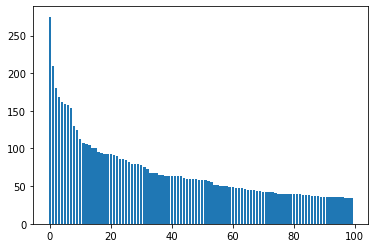

In [10]:
plt.bar(range(100), [words[w] for w in sorted_words[:100]])
plt.show()

In [11]:
vectorizer = CountVectorizer(binary=True)
x_train_cv = vectorizer.fit_transform(x_train_text)
x_test_cv = vectorizer.transform(x_test_text)

In [12]:
print('Before Vectorize: ', x_train_text[3])

Before Vectorize:  next train sure identifies train tram 🤦 🏻 ‍ ♀ ️


In [13]:
# Notice that the matriz is sparse
print('After Vectorize: ')
print(x_train_cv[3])

After Vectorize: 
  (0, 5091)	1
  (0, 7743)	1
  (0, 7356)	1
  (0, 3700)	1
  (0, 7749)	1


In [14]:
def set_device():
    device = "cuda" if torch.cuda.is_available() else "cpu"
    if device != "cuda":
        print("WARNING: For this notebook to perform best, if possible, in the menu under `Runtime` -> `Change runtime type.`  select `GPU` ")
    else:
        print("GPU is enabled in this notebook.")

    return device

In [15]:
# Set the device (check if gpu is available)
device = set_device()
#First we will create a Dictionary (`word_to_idx`). 
#This dictionary will map each Token (usually words) to an index (an integer number). 
#We want to limit our dictionary to a certain number of tokens (`num_words_dict`), so we will include in our ditionary those with more occurrences.

In [16]:
#Let's select only the most used.
num_words_dict = 5000
# We reserve two numbers for special tokens.
most_used_words = sorted_words[:num_words_dict-2]

In [17]:
#We will add two extra Tokens to the dictionary, one for words outside the dictionary (`'UNK'`) and one for padding the sequences (`'PAD'`).
# dictionary to go from words to idx 
word_to_idx = {}
# dictionary to go from idx to words (just in case) 
idx_to_word = {}


# We include the special tokens first
PAD_token = 0   
UNK_token = 1

word_to_idx['PAD'] = PAD_token
word_to_idx['UNK'] = UNK_token

idx_to_word[PAD_token] = 'PAD'
idx_to_word[UNK_token] = 'UNK'

# We popullate our dictionaries with the most used words
for num,word in enumerate(most_used_words):
    word_to_idx[word] = num + 2
    idx_to_word[num+2] = word

In [18]:
#Our goal now is to transform each tweet from a sequence of tokens to a sequence of indexes. These sequences of indexes will be the input to our pytorch model.
# A function to convert list of tokens to list of indexes
def tokens_to_idx(sentences_tokens,word_to_idx):
    sentences_idx = []
    for sent in sentences_tokens:
        sent_idx = []
        for word in sent:
            if word in word_to_idx:
                sent_idx.append(word_to_idx[word])
            else:
                sent_idx.append(word_to_idx['UNK'])
        sentences_idx.append(sent_idx)
    return sentences_idx

In [19]:
x_train_idx = tokens_to_idx(x_train_token,word_to_idx)
x_test_idx = tokens_to_idx(x_test_token,word_to_idx)
len(x_train_idx), len(x_test_idx)

(2835, 709)

In [20]:
some_number = 1
print('Before converting: ', x_train_token[some_number])
print('After converting: ', x_train_idx[some_number])

Before converting:  ['good']
After converting:  [12]


In [21]:
#We need all the sequences to have the same length. To select an adequate sequence length, let's explore some statistics about the length of the tweets:
tweet_lens = np.asarray([len(sentence) for sentence in x_train_idx])
print('Max tweet word length: ',tweet_lens.max())
print('Mean tweet word length: ',np.median(tweet_lens))
print('99% percent under: ',np.quantile(tweet_lens,0.99))

Max tweet word length:  50
Mean tweet word length:  9.0
99% percent under:  29.0


In [22]:
#We cut the sequences which are larger than our chosen maximum length (`max_lenght`) and fill with zeros the ones that are shorter.
 # We choose the max length
max_length = 30

# A function to make all the sequence have the same lenght
# Note that the output is a Numpy matrix
def padding(sentences, seq_len):
    features = np.zeros((len(sentences), seq_len),dtype=int)
    for ii, tweet in enumerate(sentences):
        len_tweet = len(tweet) 
        if len_tweet != 0:
            if len_tweet <= seq_len:
        # If its shorter, we fill with zeros (the padding Token index)
                features[ii, -len(tweet):] = np.array(tweet)[:seq_len]
            if len_tweet > seq_len:
        # If its larger, we take the last 'seq_len' indexes
                features[ii, :] = np.array(tweet)[-seq_len:]
    return features

In [23]:
# We convert our list of tokens into a numpy matrix
# where all instances have the same lenght
x_train_pad = padding(x_train_idx,max_length)
x_test_pad = padding(x_test_idx,max_length)

# We convert our target list a numpy matrix
y_train_np = np.asarray(y_train)
y_test_np = np.asarray(y_test)

In [24]:
some_number = 2
print('Before padding: ', x_train_idx[some_number])
print('After padding: ', x_train_pad[some_number])

Before padding:  [1540, 109, 831, 3367, 6, 2102, 3368]
After padding:  [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0 1540  109  831 3367    6
 2102 3368]


In [25]:
# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(x_train_pad), torch.from_numpy(y_train_np))
valid_data = TensorDataset(torch.from_numpy(x_test_pad), torch.from_numpy(y_test_np))

# Batch size (this is an important hyperparameter)
batch_size = 100

# dataloaders
# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size,drop_last = True)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size,drop_last = True)

In [26]:
x_train_pad.shape, x_test_pad.shape, y_train_np.shape, y_test_np.shape

((2835, 30), (709, 30), (2835,), (709,))

In [27]:
# Obtain one batch of training data
dataiter = iter(train_loader)
sample_x, sample_y = dataiter.next()

print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print('Sample input: \n', sample_y)

Sample input size:  torch.Size([100, 30])
Sample input: 
 tensor([[   0,    0,    0,  ..., 1698,  244, 4004],
        [   0,    0,    0,  ..., 1527,  454,    1],
        [   0,    0,    0,  ...,  184,  184,  184],
        ...,
        [   0,    0,    0,  ...,  135,    4,    1],
        [   0,    0,    0,  ..., 1638, 4492,  213],
        [   0,    0,    0,  ...,    6,  469,  115]])
Sample input: 
 tensor([1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0,
        0, 0, 0, 0])


Now, we will define the `SentimentRNN` class. Most of the model's class will be familiar to you, but there are two important layers we would like you to pay attention to:

*   Embedding Layer
> This layer is like a linear layer, but it makes it posible to use a sequence of inedexes as inputs (instead of a sequence of one-hot-encoded vectors). During training, the Embedding layer learns a linear transformation from the space of words (a vector space of dimension `num_words_dict`) into the a new, smaller, vector space of dimension `embedding_dim`. We suggest you to read this [thread](https://discuss.pytorch.org/t/how-does-nn-embedding-work/88518/3) and the [pytorch documentation](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html) if you want to learn more about this particular kind of layers.


*   LSTM layer
> This is one of the most used class of Recurrent Neural Networks. In Pytorch we can add several stacked layers in just one line of code. In our case, the number of layers added are decided with the parameter `no_layers`. If you want to learn more about LSTMs we strongly recommend you this [Colahs thread](https://colah.github.io/posts/2015-08-Understanding-LSTMs/) about them.








In [28]:
class SentimentRNN(nn.Module):
    def __init__(self,no_layers,vocab_size,hidden_dim,embedding_dim,drop_prob=0.1):
        super(SentimentRNN,self).__init__()

        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.no_layers = no_layers
        self.vocab_size = vocab_size
        self.drop_prob = drop_prob

    # Embedding Layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

    # LSTM Layers
        self.lstm = nn.LSTM(input_size=embedding_dim,hidden_size=self.hidden_dim,
                            num_layers=no_layers, batch_first=True, 
                            dropout=self.drop_prob)

    # Dropout layer
        self.dropout = nn.Dropout(drop_prob)

    # Linear and Sigmoid layer
        self.fc = nn.Linear(self.hidden_dim, output_dim)
        self.sig = nn.Sigmoid()
      
    def forward(self,x,hidden):
        batch_size = x.size(0)

    # Embedding out
        embeds = self.embedding(x)
    #Shape: [batch_size x max_length x embedding_dim]

    # LSTM out
        lstm_out, hidden = self.lstm(embeds, hidden)
    # Shape: [batch_size x max_length x hidden_dim]

    # Select the activation of the last Hidden Layer
        #lstm_out = lstm_out[:,-1,:].contiguous()
    # Shape: [batch_size x hidden_dim]

    ## You can instead average the activations across all the times
        lstm_out = torch.mean(lstm_out, 1).contiguous()

    # Dropout and Fully connected layer
        out = self.dropout(lstm_out)
        out = self.fc(out)

    # Sigmoid function
        sig_out = self.sig(out)

    # return last sigmoid output and hidden state
        return sig_out, hidden

    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
    # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
    # initialized to zero, for hidden state and cell state of LSTM
        h0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        c0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        hidden = (h0,c0)
        return hidden

In [29]:
# Parameters of our network

# Size of our vocabulary
vocab_size = num_words_dict

# Embedding dimension
embedding_dim = 32

# Number of stacked LSTM layers
no_layers = [2,4,8]

# Dimension of the hidden layer in LSTMs
hidden_dim = [32,64,128]

# Dropout parameter for regularization
output_dim = 1

# Dropout parameter for regularization
drop_prob = 0.25

In [30]:
# Let's define our model
model = SentimentRNN(no_layers[0], vocab_size, hidden_dim[0],
                     embedding_dim, drop_prob=drop_prob)
# Moving to gpu
model.to(device)
print(model)

SentimentRNN(
  (embedding): Embedding(5000, 32)
  (lstm): LSTM(32, 32, num_layers=2, batch_first=True, dropout=0.25)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc): Linear(in_features=32, out_features=1, bias=True)
  (sig): Sigmoid()
)


In [31]:
# How many trainable parameters does our model have?
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print('Total Number of parameters: ',params)

Total Number of parameters:  176929


In [32]:
# loss and optimization functions
lrs = np.linspace(0.0005,0.0007,3)#define a range of learning rates

# Binary crossentropy is a good loss function for a binary classification problem
criterion = nn.BCELoss()

# We choose an Adam optimizer
optimizers = []
for i,lr in enumerate(lrs):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    optimizers.append(optimizer)
# function to predict accuracy
def acc(pred,label):
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == label.squeeze()).item()

In [33]:
# Number of training Epochs
epochs = 5

# Maximum absolute value accepted for the gradeint
clip = 5

# Initial Loss value (assumed big)
valid_loss_min = np.Inf

# Lists to follow the evolution of the loss and accuracy
epoch_tr_loss,epoch_vl_loss = [[] for i in range(len(lrs))],[[] for i in range(len(lrs))]
epoch_tr_acc,epoch_vl_acc = [[] for i in range(len(lrs))],[[] for i in range(len(lrs))]

# Train for a number of Epochs
for i, lr in enumerate(lrs):
    for epoch in range(epochs):
        train_losses = []
        train_acc = 0.0
        model.train()
  
        for inputs, labels in train_loader:

    # Initialize hidden state 
            h = model.init_hidden(batch_size)
    # Creating new variables for the hidden state
            h = tuple([each.data.to(device) for each in h])

    # Move batch inputs and labels to gpu
            inputs, labels = inputs.to(device), labels.to(device)   

    # Set gradient to zero
            model.zero_grad()

    # Compute model output
            output,h = model(inputs,h)

    # Calculate the loss and perform backprop
            loss = criterion(output.squeeze(), labels.float())
            loss.backward()
            train_losses.append(loss.item())

    # calculating accuracy
            accuracy = acc(output,labels)
            train_acc += accuracy

    #`clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
            nn.utils.clip_grad_norm_(model.parameters(), clip)
            optimizers[i].step()

  
  # Evaluate on the validation set for this epoch 
        val_losses = []
        val_acc = 0.0
        model.eval()
        for inputs, labels in valid_loader:

    # Initialize hidden state 
            val_h = model.init_hidden(batch_size)
            val_h = tuple([each.data.to(device) for each in val_h])

    # Move batch inputs and labels to gpu
            inputs, labels = inputs.to(device), labels.to(device)

    # Compute model output
            output, val_h = model(inputs, val_h)

    # Compute Loss
            val_loss = criterion(output.squeeze(), labels.float())

            val_losses.append(val_loss.item())

            accuracy = acc(output,labels)
            val_acc += accuracy
          
        epoch_train_loss = np.mean(train_losses)
        epoch_val_loss = np.mean(val_losses)
        epoch_train_acc = train_acc/len(train_loader.dataset)
        epoch_val_acc = val_acc/len(valid_loader.dataset)
        epoch_tr_loss[i].append(epoch_train_loss)
        epoch_vl_loss[i].append(epoch_val_loss)
        epoch_tr_acc[i].append(epoch_train_acc)
        epoch_vl_acc[i].append(epoch_val_acc)
        print(f'Epoch {epoch+1}') 
        print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
        print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}')
        if epoch_val_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,epoch_val_loss))
    # torch.save(model.state_dict(), '../working/state_dict.pt')
            valid_loss_min = epoch_val_loss
        print(25*'==')

Epoch 1
train_loss : 0.5882232040166855 val_loss : 0.5250323287078312
train_accuracy : 81.83421516754849 val_accuracy : 81.66431593794076
Validation loss decreased (inf --> 0.525032).  Saving model ...
Epoch 2
train_loss : 0.4835419175880296 val_loss : 0.4608961471489498
train_accuracy : 81.9753086419753 val_accuracy : 82.08744710860366
Validation loss decreased (0.525032 --> 0.460896).  Saving model ...
Epoch 3
train_loss : 0.4681631454399654 val_loss : 0.46324083634785246
train_accuracy : 81.7636684303351 val_accuracy : 81.66431593794076
Epoch 4
train_loss : 0.4615811641727175 val_loss : 0.450365275144577
train_accuracy : 81.9047619047619 val_accuracy : 82.36953455571228
Validation loss decreased (0.460896 --> 0.450365).  Saving model ...
Epoch 5
train_loss : 0.4643903523683548 val_loss : 0.45662370324134827
train_accuracy : 81.83421516754849 val_accuracy : 81.94640338504936
Epoch 1
train_loss : 0.4623623075229781 val_loss : 0.458415870155607
train_accuracy : 81.8694885361552 val_acc

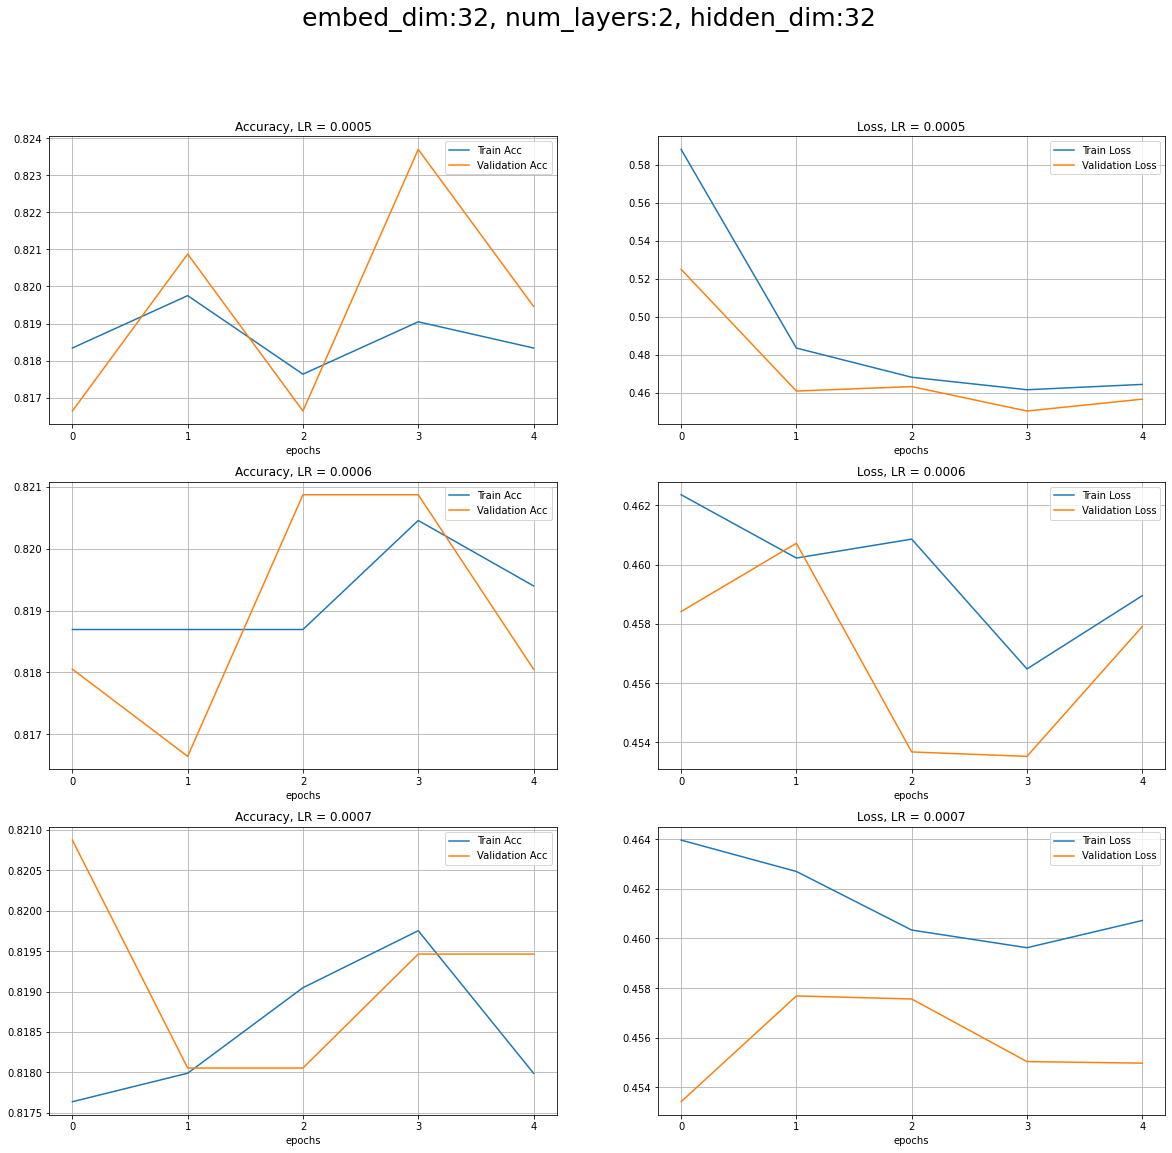

In [37]:
fig, ax = plt.subplots(len(lrs),2, figsize = (20,len(lrs)*6))
plt.suptitle(r'embed_dim:%d, num_layers:%d, hidden_dim:%d'%(embedding_dim, no_layers[0], hidden_dim[0]), fontsize = 25)
for i, lr in enumerate(lrs):
    ax[i][0].plot(epoch_tr_acc[i], label='Train Acc')
    ax[i][0].plot(epoch_vl_acc[i], label='Validation Acc')
    ax[i][0].set_xlabel('epochs')
    ax[i][0].set_xticks([0,1,2,3,4])
    ax[i][0].set_title('Accuracy, LR = %.4f'%lr)
    ax[i][0].legend()
    ax[i][0].grid()
    
    ax[i][1].plot(epoch_tr_loss[i], label='Train Loss')
    ax[i][1].plot(epoch_vl_loss[i], label='Validation Loss')
    ax[i][1].set_xlabel('epochs')
    ax[i][1].set_xticks([0,1,2,3,4])
    ax[i][1].set_title('Loss, LR = %.4f'%lr)
    ax[i][1].legend()
    ax[i][1].grid()
plt.savefig('/Users/bengieru/Desktop/NMA-DL/iSarcasm/Results/loss_acc_embed_dim:%d, no_layers:%d, hidden_dim:%d'%(embedding_dim, no_layers[0], hidden_dim[0]))
#np.savetxt('/Users/bengieru/Desktop/NMA-DL/iSarcasm/Results/learning_rate_tr_acc.txt', epoch_tr_acc)
#np.savetxt('/Users/bengieru/Desktop/NMA-DL/iSarcasm/Results/learning_rate_tr_loss.txt', epoch_tr_loss)
#np.savetxt('/Users/bengieru/Desktop/NMA-DL/iSarcasm/Results/learning_rate_vl_loss.txt', epoch_vl_loss)
#np.savetxt('/Users/bengieru/Desktop/NMA-DL/iSarcasm/Results/learning_rate_vl_acc.txt', epoch_vl_acc)

In [38]:
# Let's define our model
model = SentimentRNN(no_layers[0], vocab_size, hidden_dim[1],
                     embedding_dim, drop_prob=drop_prob)
# Moving to gpu
model.to(device)
print(model)

SentimentRNN(
  (embedding): Embedding(5000, 32)
  (lstm): LSTM(32, 64, num_layers=2, batch_first=True, dropout=0.25)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc): Linear(in_features=64, out_features=1, bias=True)
  (sig): Sigmoid()
)


In [39]:
# How many trainable parameters does our model have?
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print('Total Number of parameters: ',params)

Total Number of parameters:  218433


In [40]:
# loss and optimization functions
lrs = np.linspace(0.0005,0.0007,3)#define a range of learning rates

# Binary crossentropy is a good loss function for a binary classification problem
criterion = nn.BCELoss()

# We choose an Adam optimizer
optimizers = []
for i,lr in enumerate(lrs):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    optimizers.append(optimizer)
# function to predict accuracy
def acc(pred,label):
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == label.squeeze()).item()

In [41]:
# Number of training Epochs
epochs = 5

# Maximum absolute value accepted for the gradeint
clip = 5

# Initial Loss value (assumed big)
valid_loss_min = np.Inf

# Lists to follow the evolution of the loss and accuracy
epoch_tr_loss,epoch_vl_loss = [[] for i in range(len(lrs))],[[] for i in range(len(lrs))]
epoch_tr_acc,epoch_vl_acc = [[] for i in range(len(lrs))],[[] for i in range(len(lrs))]

# Train for a number of Epochs
for i, lr in enumerate(lrs):
    for epoch in range(epochs):
        train_losses = []
        train_acc = 0.0
        model.train()
  
        for inputs, labels in train_loader:

    # Initialize hidden state 
            h = model.init_hidden(batch_size)
    # Creating new variables for the hidden state
            h = tuple([each.data.to(device) for each in h])

    # Move batch inputs and labels to gpu
            inputs, labels = inputs.to(device), labels.to(device)   

    # Set gradient to zero
            model.zero_grad()

    # Compute model output
            output,h = model(inputs,h)

    # Calculate the loss and perform backprop
            loss = criterion(output.squeeze(), labels.float())
            loss.backward()
            train_losses.append(loss.item())

    # calculating accuracy
            accuracy = acc(output,labels)
            train_acc += accuracy

    #`clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
            nn.utils.clip_grad_norm_(model.parameters(), clip)
            optimizers[i].step()

  
  # Evaluate on the validation set for this epoch 
        val_losses = []
        val_acc = 0.0
        model.eval()
        for inputs, labels in valid_loader:

    # Initialize hidden state 
            val_h = model.init_hidden(batch_size)
            val_h = tuple([each.data.to(device) for each in val_h])

    # Move batch inputs and labels to gpu
            inputs, labels = inputs.to(device), labels.to(device)

    # Compute model output
            output, val_h = model(inputs, val_h)

    # Compute Loss
            val_loss = criterion(output.squeeze(), labels.float())

            val_losses.append(val_loss.item())

            accuracy = acc(output,labels)
            val_acc += accuracy
          
        epoch_train_loss = np.mean(train_losses)
        epoch_val_loss = np.mean(val_losses)
        epoch_train_acc = train_acc/len(train_loader.dataset)
        epoch_val_acc = val_acc/len(valid_loader.dataset)
        epoch_tr_loss[i].append(epoch_train_loss)
        epoch_vl_loss[i].append(epoch_val_loss)
        epoch_tr_acc[i].append(epoch_train_acc)
        epoch_vl_acc[i].append(epoch_val_acc)
        print(f'Epoch {epoch+1}') 
        print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
        print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}')
        if epoch_val_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,epoch_val_loss))
    # torch.save(model.state_dict(), '../working/state_dict.pt')
            valid_loss_min = epoch_val_loss
        print(25*'==')

Epoch 1
train_loss : 0.5735812038183212 val_loss : 0.475680696112769
train_accuracy : 79.50617283950618 val_accuracy : 81.66431593794076
Validation loss decreased (inf --> 0.475681).  Saving model ...
Epoch 2
train_loss : 0.47532641887664795 val_loss : 0.4590836593082973
train_accuracy : 81.83421516754849 val_accuracy : 81.94640338504936
Validation loss decreased (0.475681 --> 0.459084).  Saving model ...
Epoch 3
train_loss : 0.46300990666661945 val_loss : 0.4564849393708365
train_accuracy : 81.9047619047619 val_accuracy : 81.94640338504936
Validation loss decreased (0.459084 --> 0.456485).  Saving model ...
Epoch 4
train_loss : 0.4575389783297266 val_loss : 0.4558335840702057
train_accuracy : 82.04585537918871 val_accuracy : 81.94640338504936
Validation loss decreased (0.456485 --> 0.455834).  Saving model ...
Epoch 5
train_loss : 0.4579751544765064 val_loss : 0.4579820845808302
train_accuracy : 82.04585537918871 val_accuracy : 81.80535966149506
Epoch 1
train_loss : 0.4597766356808798

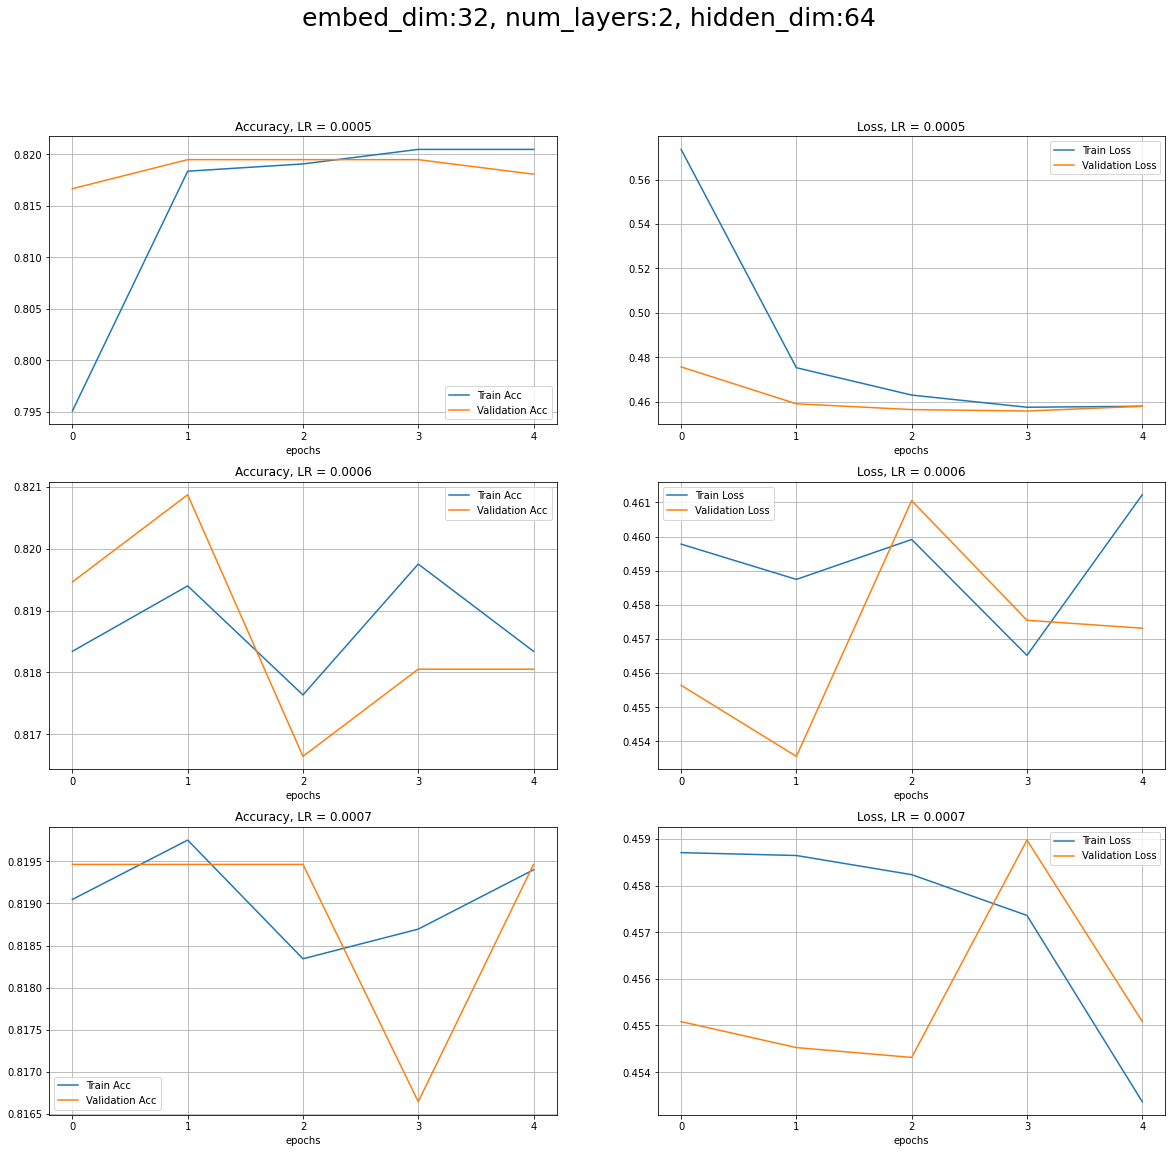

In [42]:
fig, ax = plt.subplots(len(lrs),2, figsize = (20,len(lrs)*6))
plt.suptitle(r'embed_dim:%d, num_layers:%d, hidden_dim:%d'%(embedding_dim, no_layers[0], hidden_dim[1]), fontsize = 25)
for i, lr in enumerate(lrs):
    ax[i][0].plot(epoch_tr_acc[i], label='Train Acc')
    ax[i][0].plot(epoch_vl_acc[i], label='Validation Acc')
    ax[i][0].set_xlabel('epochs')
    ax[i][0].set_xticks([0,1,2,3,4])
    ax[i][0].set_title('Accuracy, LR = %.4f'%lr)
    ax[i][0].legend()
    ax[i][0].grid()
    
    ax[i][1].plot(epoch_tr_loss[i], label='Train Loss')
    ax[i][1].plot(epoch_vl_loss[i], label='Validation Loss')
    ax[i][1].set_xlabel('epochs')
    ax[i][1].set_xticks([0,1,2,3,4])
    ax[i][1].set_title('Loss, LR = %.4f'%lr)
    ax[i][1].legend()
    ax[i][1].grid()
plt.savefig('/Users/bengieru/Desktop/NMA-DL/iSarcasm/Results/loss_acc_embed_dim:%d, no_layers:%d, hidden_dim:%d'%(embedding_dim, no_layers[0], hidden_dim[1]))

In [43]:
# Let's define our model
model = SentimentRNN(no_layers[0], vocab_size, hidden_dim[2],
                     embedding_dim, drop_prob=drop_prob)
# Moving to gpu
model.to(device)
print(model)

SentimentRNN(
  (embedding): Embedding(5000, 32)
  (lstm): LSTM(32, 128, num_layers=2, batch_first=True, dropout=0.25)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (sig): Sigmoid()
)


In [44]:
# How many trainable parameters does our model have?
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print('Total Number of parameters: ',params)

Total Number of parameters:  375169


In [45]:
# loss and optimization functions
lrs = np.linspace(0.0005,0.0007,3)#define a range of learning rates

# Binary crossentropy is a good loss function for a binary classification problem
criterion = nn.BCELoss()

# We choose an Adam optimizer
optimizers = []
for i,lr in enumerate(lrs):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    optimizers.append(optimizer)
# function to predict accuracy
def acc(pred,label):
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == label.squeeze()).item()

In [46]:
# Number of training Epochs
epochs = 5

# Maximum absolute value accepted for the gradeint
clip = 5

# Initial Loss value (assumed big)
valid_loss_min = np.Inf

# Lists to follow the evolution of the loss and accuracy
epoch_tr_loss,epoch_vl_loss = [[] for i in range(len(lrs))],[[] for i in range(len(lrs))]
epoch_tr_acc,epoch_vl_acc = [[] for i in range(len(lrs))],[[] for i in range(len(lrs))]

# Train for a number of Epochs
for i, lr in enumerate(lrs):
    for epoch in range(epochs):
        train_losses = []
        train_acc = 0.0
        model.train()
  
        for inputs, labels in train_loader:

    # Initialize hidden state 
            h = model.init_hidden(batch_size)
    # Creating new variables for the hidden state
            h = tuple([each.data.to(device) for each in h])

    # Move batch inputs and labels to gpu
            inputs, labels = inputs.to(device), labels.to(device)   

    # Set gradient to zero
            model.zero_grad()

    # Compute model output
            output,h = model(inputs,h)

    # Calculate the loss and perform backprop
            loss = criterion(output.squeeze(), labels.float())
            loss.backward()
            train_losses.append(loss.item())

    # calculating accuracy
            accuracy = acc(output,labels)
            train_acc += accuracy

    #`clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
            nn.utils.clip_grad_norm_(model.parameters(), clip)
            optimizers[i].step()

  
  # Evaluate on the validation set for this epoch 
        val_losses = []
        val_acc = 0.0
        model.eval()
        for inputs, labels in valid_loader:

    # Initialize hidden state 
            val_h = model.init_hidden(batch_size)
            val_h = tuple([each.data.to(device) for each in val_h])

    # Move batch inputs and labels to gpu
            inputs, labels = inputs.to(device), labels.to(device)

    # Compute model output
            output, val_h = model(inputs, val_h)

    # Compute Loss
            val_loss = criterion(output.squeeze(), labels.float())

            val_losses.append(val_loss.item())

            accuracy = acc(output,labels)
            val_acc += accuracy
          
        epoch_train_loss = np.mean(train_losses)
        epoch_val_loss = np.mean(val_losses)
        epoch_train_acc = train_acc/len(train_loader.dataset)
        epoch_val_acc = val_acc/len(valid_loader.dataset)
        epoch_tr_loss[i].append(epoch_train_loss)
        epoch_vl_loss[i].append(epoch_val_loss)
        epoch_tr_acc[i].append(epoch_train_acc)
        epoch_vl_acc[i].append(epoch_val_acc)
        print(f'Epoch {epoch+1}') 
        print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
        print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}')
        if epoch_val_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,epoch_val_loss))
    # torch.save(model.state_dict(), '../working/state_dict.pt')
            valid_loss_min = epoch_val_loss
        print(25*'==')

Epoch 1
train_loss : 0.5450742851410594 val_loss : 0.4698759359972818
train_accuracy : 78.37742504409171 val_accuracy : 81.94640338504936
Validation loss decreased (inf --> 0.469876).  Saving model ...
Epoch 2
train_loss : 0.46609351464680265 val_loss : 0.45582487327711924
train_accuracy : 81.9753086419753 val_accuracy : 82.08744710860366
Validation loss decreased (0.469876 --> 0.455825).  Saving model ...
Epoch 3
train_loss : 0.4605769408600671 val_loss : 0.45803678035736084
train_accuracy : 81.8694885361552 val_accuracy : 81.80535966149506
Epoch 4
train_loss : 0.45785579830408096 val_loss : 0.4574915553842272
train_accuracy : 81.9753086419753 val_accuracy : 81.80535966149506
Epoch 5
train_loss : 0.45934934275490896 val_loss : 0.4524920071874346
train_accuracy : 81.8694885361552 val_accuracy : 82.08744710860366
Validation loss decreased (0.455825 --> 0.452492).  Saving model ...
Epoch 1
train_loss : 0.4594330329980169 val_loss : 0.4606320134231022
train_accuracy : 81.94003527336861 va

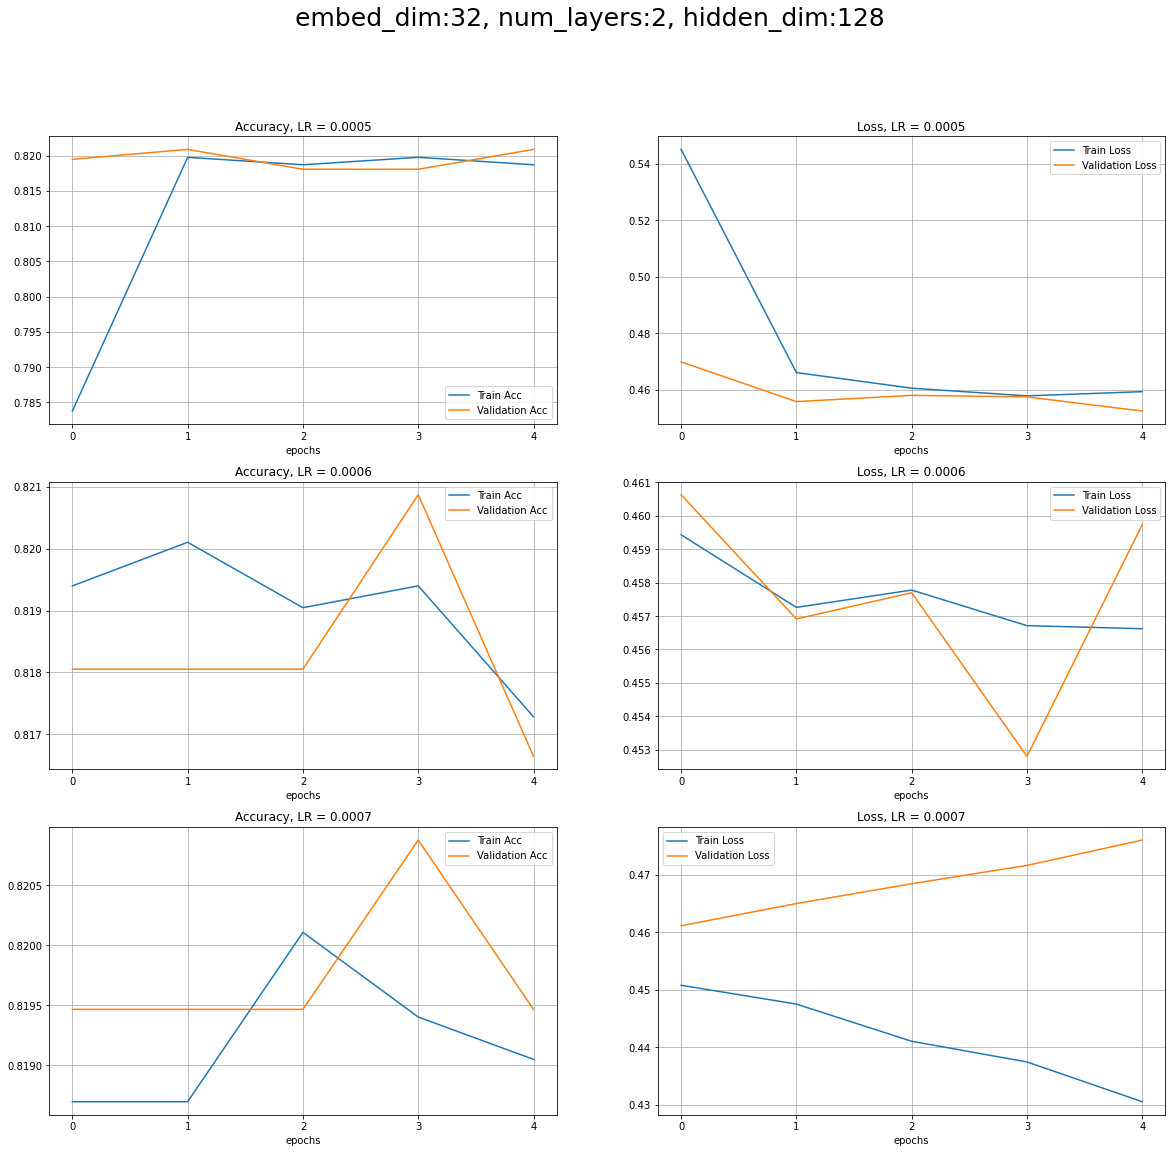

In [47]:
fig, ax = plt.subplots(len(lrs),2, figsize = (20,len(lrs)*6))
plt.suptitle(r'embed_dim:%d, num_layers:%d, hidden_dim:%d'%(embedding_dim, no_layers[0], hidden_dim[2]), fontsize = 25)
for i, lr in enumerate(lrs):
    ax[i][0].plot(epoch_tr_acc[i], label='Train Acc')
    ax[i][0].plot(epoch_vl_acc[i], label='Validation Acc')
    ax[i][0].set_xlabel('epochs')
    ax[i][0].set_xticks([0,1,2,3,4])
    ax[i][0].set_title('Accuracy, LR = %.4f'%lr)
    ax[i][0].legend()
    ax[i][0].grid()
    
    ax[i][1].plot(epoch_tr_loss[i], label='Train Loss')
    ax[i][1].plot(epoch_vl_loss[i], label='Validation Loss')
    ax[i][1].set_xlabel('epochs')
    ax[i][1].set_xticks([0,1,2,3,4])
    ax[i][1].set_title('Loss, LR = %.4f'%lr)
    ax[i][1].legend()
    ax[i][1].grid()
plt.savefig('/Users/bengieru/Desktop/NMA-DL/iSarcasm/Results/loss_acc_embed_dim:%d, no_layers:%d, hidden_dim:%d'%(embedding_dim, no_layers[0], hidden_dim[2]))

In [48]:
# Let's define our model
model = SentimentRNN(no_layers[1], vocab_size, hidden_dim[0],
                     embedding_dim, drop_prob=drop_prob)
# Moving to gpu
model.to(device)
print(model)

SentimentRNN(
  (embedding): Embedding(5000, 32)
  (lstm): LSTM(32, 32, num_layers=4, batch_first=True, dropout=0.25)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc): Linear(in_features=32, out_features=1, bias=True)
  (sig): Sigmoid()
)


In [49]:
# How many trainable parameters does our model have?
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print('Total Number of parameters: ',params)

Total Number of parameters:  193825


In [50]:
# loss and optimization functions
lrs = np.linspace(0.0005,0.0007,3)#define a range of learning rates

# Binary crossentropy is a good loss function for a binary classification problem
criterion = nn.BCELoss()

# We choose an Adam optimizer
optimizers = []
for i,lr in enumerate(lrs):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    optimizers.append(optimizer)
# function to predict accuracy
def acc(pred,label):
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == label.squeeze()).item()

In [51]:
# Number of training Epochs
epochs = 5

# Maximum absolute value accepted for the gradeint
clip = 5

# Initial Loss value (assumed big)
valid_loss_min = np.Inf

# Lists to follow the evolution of the loss and accuracy
epoch_tr_loss,epoch_vl_loss = [[] for i in range(len(lrs))],[[] for i in range(len(lrs))]
epoch_tr_acc,epoch_vl_acc = [[] for i in range(len(lrs))],[[] for i in range(len(lrs))]

# Train for a number of Epochs
for i, lr in enumerate(lrs):
    for epoch in range(epochs):
        train_losses = []
        train_acc = 0.0
        model.train()
  
        for inputs, labels in train_loader:

    # Initialize hidden state 
            h = model.init_hidden(batch_size)
    # Creating new variables for the hidden state
            h = tuple([each.data.to(device) for each in h])

    # Move batch inputs and labels to gpu
            inputs, labels = inputs.to(device), labels.to(device)   

    # Set gradient to zero
            model.zero_grad()

    # Compute model output
            output,h = model(inputs,h)

    # Calculate the loss and perform backprop
            loss = criterion(output.squeeze(), labels.float())
            loss.backward()
            train_losses.append(loss.item())

    # calculating accuracy
            accuracy = acc(output,labels)
            train_acc += accuracy

    #`clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
            nn.utils.clip_grad_norm_(model.parameters(), clip)
            optimizers[i].step()

  
  # Evaluate on the validation set for this epoch 
        val_losses = []
        val_acc = 0.0
        model.eval()
        for inputs, labels in valid_loader:

    # Initialize hidden state 
            val_h = model.init_hidden(batch_size)
            val_h = tuple([each.data.to(device) for each in val_h])

    # Move batch inputs and labels to gpu
            inputs, labels = inputs.to(device), labels.to(device)

    # Compute model output
            output, val_h = model(inputs, val_h)

    # Compute Loss
            val_loss = criterion(output.squeeze(), labels.float())

            val_losses.append(val_loss.item())

            accuracy = acc(output,labels)
            val_acc += accuracy
          
        epoch_train_loss = np.mean(train_losses)
        epoch_val_loss = np.mean(val_losses)
        epoch_train_acc = train_acc/len(train_loader.dataset)
        epoch_val_acc = val_acc/len(valid_loader.dataset)
        epoch_tr_loss[i].append(epoch_train_loss)
        epoch_vl_loss[i].append(epoch_val_loss)
        epoch_tr_acc[i].append(epoch_train_acc)
        epoch_vl_acc[i].append(epoch_val_acc)
        print(f'Epoch {epoch+1}') 
        print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
        print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}')
        if epoch_val_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,epoch_val_loss))
    # torch.save(model.state_dict(), '../working/state_dict.pt')
            valid_loss_min = epoch_val_loss
        print(25*'==')

Epoch 1
train_loss : 0.5916072981698173 val_loss : 0.5278055582727704
train_accuracy : 81.72839506172839 val_accuracy : 82.08744710860366
Validation loss decreased (inf --> 0.527806).  Saving model ...
Epoch 2
train_loss : 0.4793849842888968 val_loss : 0.4582956220422472
train_accuracy : 82.04585537918871 val_accuracy : 81.94640338504936
Validation loss decreased (0.527806 --> 0.458296).  Saving model ...
Epoch 3
train_loss : 0.4601243223462786 val_loss : 0.4582311936787197
train_accuracy : 81.7989417989418 val_accuracy : 81.80535966149506
Validation loss decreased (0.458296 --> 0.458231).  Saving model ...
Epoch 4
train_loss : 0.4608582726546696 val_loss : 0.45596739649772644
train_accuracy : 81.9047619047619 val_accuracy : 81.94640338504936
Validation loss decreased (0.458231 --> 0.455967).  Saving model ...
Epoch 5
train_loss : 0.45950494493756977 val_loss : 0.4583830918584551
train_accuracy : 81.9047619047619 val_accuracy : 81.80535966149506
Epoch 1
train_loss : 0.46112118874277386

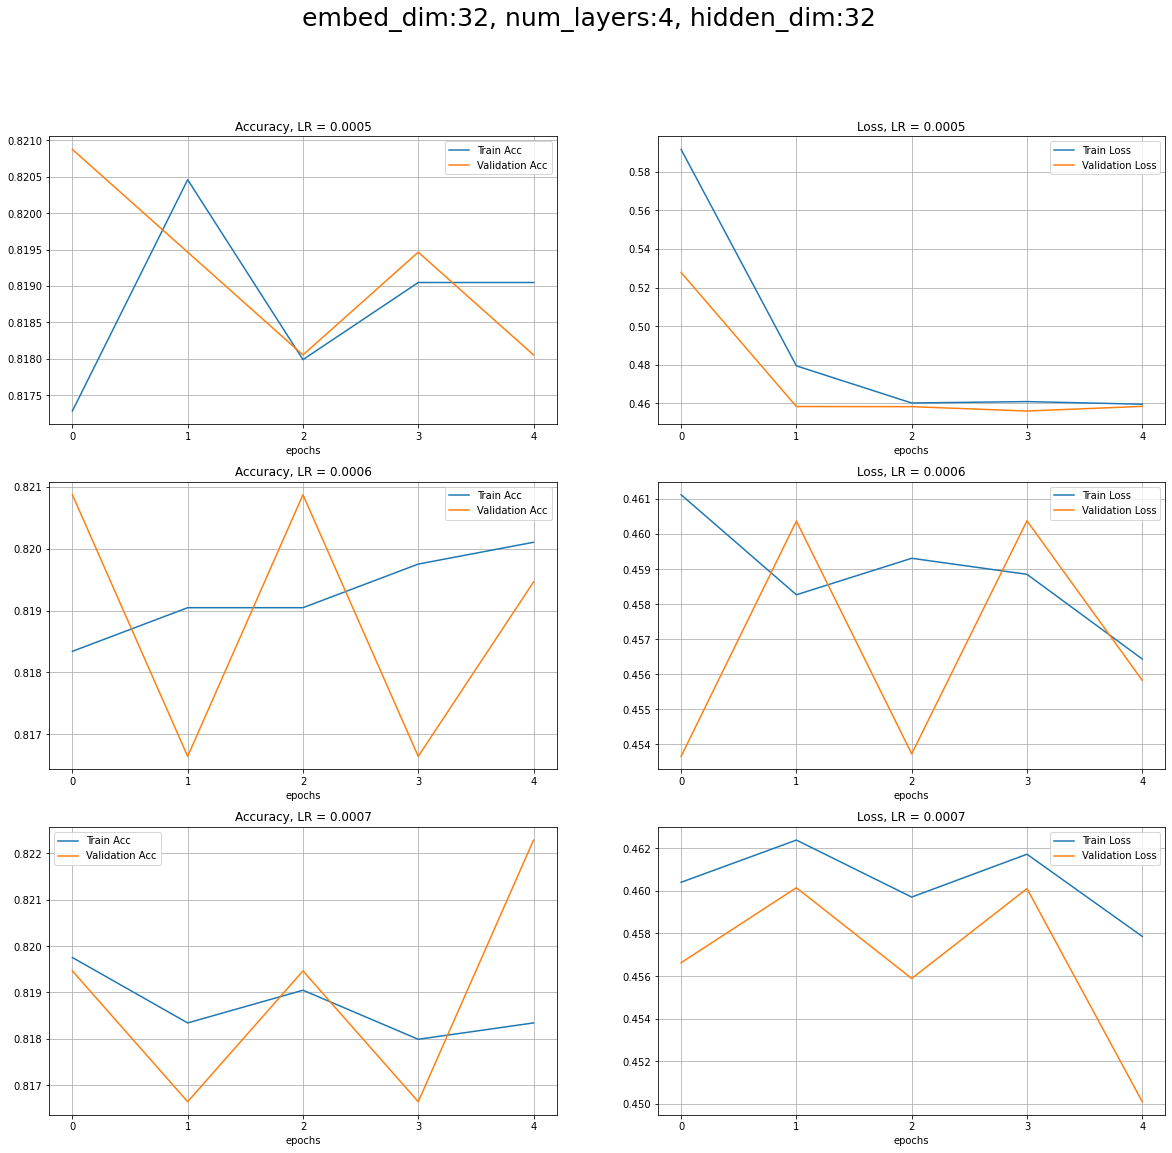

In [52]:
fig, ax = plt.subplots(len(lrs),2, figsize = (20,len(lrs)*6))
plt.suptitle(r'embed_dim:%d, num_layers:%d, hidden_dim:%d'%(embedding_dim, no_layers[1], hidden_dim[0]), fontsize = 25)
for i, lr in enumerate(lrs):
    ax[i][0].plot(epoch_tr_acc[i], label='Train Acc')
    ax[i][0].plot(epoch_vl_acc[i], label='Validation Acc')
    ax[i][0].set_xlabel('epochs')
    ax[i][0].set_xticks([0,1,2,3,4])
    ax[i][0].set_title('Accuracy, LR = %.4f'%lr)
    ax[i][0].legend()
    ax[i][0].grid()
    
    ax[i][1].plot(epoch_tr_loss[i], label='Train Loss')
    ax[i][1].plot(epoch_vl_loss[i], label='Validation Loss')
    ax[i][1].set_xlabel('epochs')
    ax[i][1].set_xticks([0,1,2,3,4])
    ax[i][1].set_title('Loss, LR = %.4f'%lr)
    ax[i][1].legend()
    ax[i][1].grid()
plt.savefig('/Users/bengieru/Desktop/NMA-DL/iSarcasm/Results/loss_acc_embed_dim:%d, no_layers:%d, hidden_dim:%d'%(embedding_dim, no_layers[1], hidden_dim[0]))

In [53]:
# Let's define our model
model = SentimentRNN(no_layers[1], vocab_size, hidden_dim[1],
                     embedding_dim, drop_prob=drop_prob)
# Moving to gpu
model.to(device)
print(model)

SentimentRNN(
  (embedding): Embedding(5000, 32)
  (lstm): LSTM(32, 64, num_layers=4, batch_first=True, dropout=0.25)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc): Linear(in_features=64, out_features=1, bias=True)
  (sig): Sigmoid()
)


In [54]:
# How many trainable parameters does our model have?
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print('Total Number of parameters: ',params)

Total Number of parameters:  284993


In [55]:
# loss and optimization functions
lrs = np.linspace(0.0005,0.0007,3)#define a range of learning rates

# Binary crossentropy is a good loss function for a binary classification problem
criterion = nn.BCELoss()

# We choose an Adam optimizer
optimizers = []
for i,lr in enumerate(lrs):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    optimizers.append(optimizer)
# function to predict accuracy
def acc(pred,label):
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == label.squeeze()).item()

In [56]:
# Number of training Epochs
epochs = 5

# Maximum absolute value accepted for the gradeint
clip = 5

# Initial Loss value (assumed big)
valid_loss_min = np.Inf

# Lists to follow the evolution of the loss and accuracy
epoch_tr_loss,epoch_vl_loss = [[] for i in range(len(lrs))],[[] for i in range(len(lrs))]
epoch_tr_acc,epoch_vl_acc = [[] for i in range(len(lrs))],[[] for i in range(len(lrs))]

# Train for a number of Epochs
for i, lr in enumerate(lrs):
    for epoch in range(epochs):
        train_losses = []
        train_acc = 0.0
        model.train()
  
        for inputs, labels in train_loader:

    # Initialize hidden state 
            h = model.init_hidden(batch_size)
    # Creating new variables for the hidden state
            h = tuple([each.data.to(device) for each in h])

    # Move batch inputs and labels to gpu
            inputs, labels = inputs.to(device), labels.to(device)   

    # Set gradient to zero
            model.zero_grad()

    # Compute model output
            output,h = model(inputs,h)

    # Calculate the loss and perform backprop
            loss = criterion(output.squeeze(), labels.float())
            loss.backward()
            train_losses.append(loss.item())

    # calculating accuracy
            accuracy = acc(output,labels)
            train_acc += accuracy

    #`clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
            nn.utils.clip_grad_norm_(model.parameters(), clip)
            optimizers[i].step()

  
  # Evaluate on the validation set for this epoch 
        val_losses = []
        val_acc = 0.0
        model.eval()
        for inputs, labels in valid_loader:

    # Initialize hidden state 
            val_h = model.init_hidden(batch_size)
            val_h = tuple([each.data.to(device) for each in val_h])

    # Move batch inputs and labels to gpu
            inputs, labels = inputs.to(device), labels.to(device)

    # Compute model output
            output, val_h = model(inputs, val_h)

    # Compute Loss
            val_loss = criterion(output.squeeze(), labels.float())

            val_losses.append(val_loss.item())

            accuracy = acc(output,labels)
            val_acc += accuracy
          
        epoch_train_loss = np.mean(train_losses)
        epoch_val_loss = np.mean(val_losses)
        epoch_train_acc = train_acc/len(train_loader.dataset)
        epoch_val_acc = val_acc/len(valid_loader.dataset)
        epoch_tr_loss[i].append(epoch_train_loss)
        epoch_vl_loss[i].append(epoch_val_loss)
        epoch_tr_acc[i].append(epoch_train_acc)
        epoch_vl_acc[i].append(epoch_val_acc)
        print(f'Epoch {epoch+1}') 
        print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
        print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}')
        if epoch_val_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,epoch_val_loss))
    # torch.save(model.state_dict(), '../working/state_dict.pt')
            valid_loss_min = epoch_val_loss
        print(25*'==')

Epoch 1
train_loss : 0.6428013305578913 val_loss : 0.4601999989577702
train_accuracy : 56.119929453262785 val_accuracy : 82.08744710860366
Validation loss decreased (inf --> 0.460200).  Saving model ...
Epoch 2
train_loss : 0.46098175432000843 val_loss : 0.45602118968963623
train_accuracy : 81.9753086419753 val_accuracy : 81.94640338504936
Validation loss decreased (0.460200 --> 0.456021).  Saving model ...
Epoch 3
train_loss : 0.45776140157665524 val_loss : 0.45128057258469717
train_accuracy : 82.11640211640213 val_accuracy : 82.22849083215797
Validation loss decreased (0.456021 --> 0.451281).  Saving model ...
Epoch 4
train_loss : 0.45749014083828243 val_loss : 0.45591066564832416
train_accuracy : 82.01058201058201 val_accuracy : 81.94640338504936
Epoch 5
train_loss : 0.4605429598263332 val_loss : 0.45588806697300505
train_accuracy : 81.9753086419753 val_accuracy : 81.94640338504936
Epoch 1
train_loss : 0.45884360692330767 val_loss : 0.45817390935761587
train_accuracy : 81.8342151675

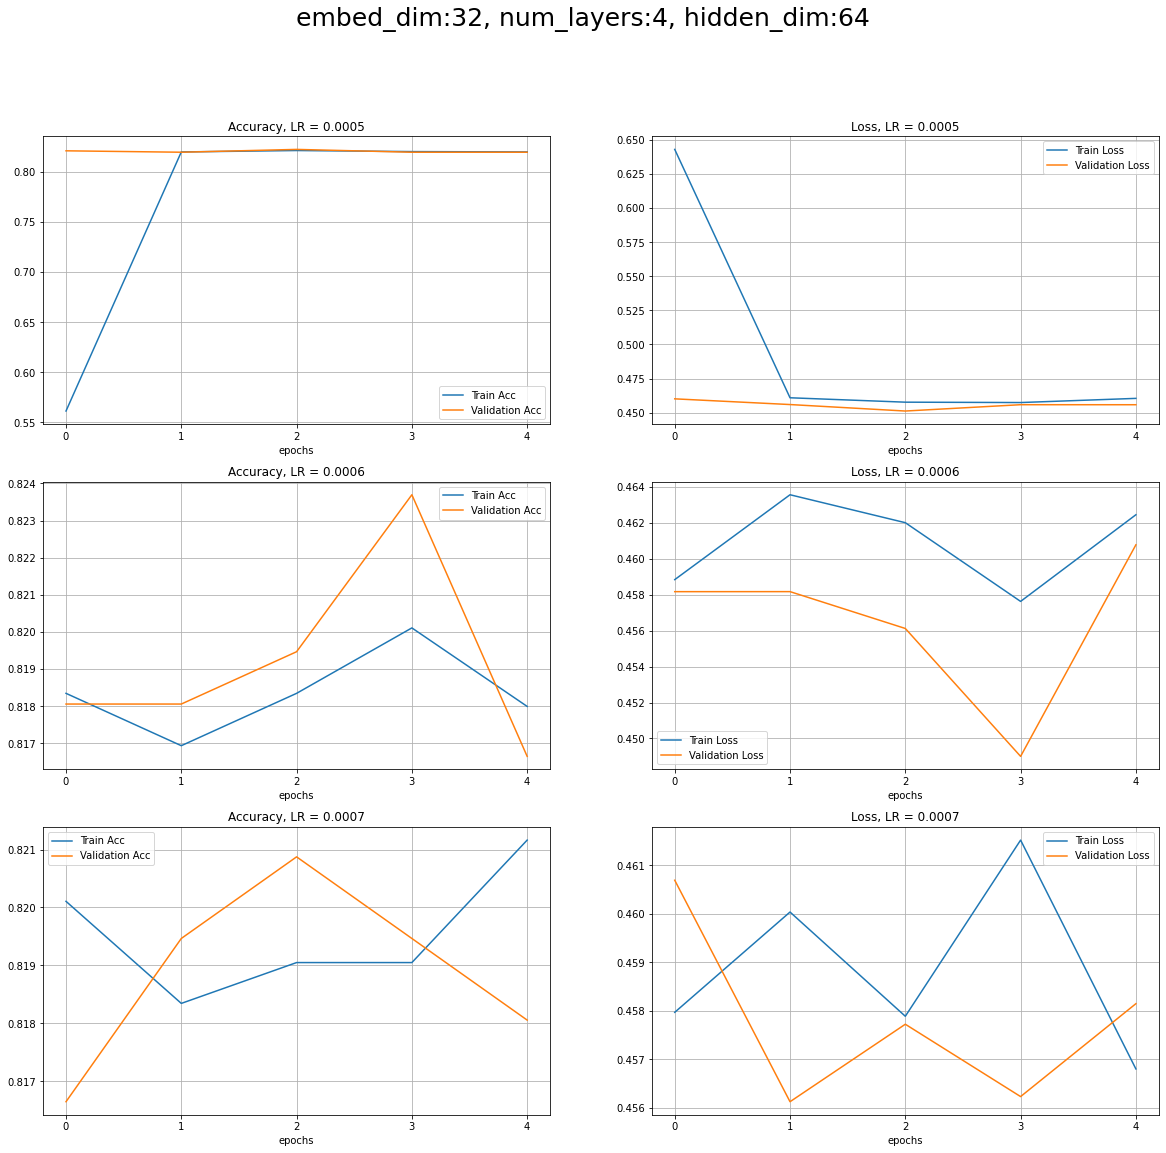

In [57]:
fig, ax = plt.subplots(len(lrs),2, figsize = (20,len(lrs)*6))
plt.suptitle(r'embed_dim:%d, num_layers:%d, hidden_dim:%d'%(embedding_dim, no_layers[1], hidden_dim[1]), fontsize = 25)
for i, lr in enumerate(lrs):
    ax[i][0].plot(epoch_tr_acc[i], label='Train Acc')
    ax[i][0].plot(epoch_vl_acc[i], label='Validation Acc')
    ax[i][0].set_xlabel('epochs')
    ax[i][0].set_xticks([0,1,2,3,4])
    ax[i][0].set_title('Accuracy, LR = %.4f'%lr)
    ax[i][0].legend()
    ax[i][0].grid()
    
    ax[i][1].plot(epoch_tr_loss[i], label='Train Loss')
    ax[i][1].plot(epoch_vl_loss[i], label='Validation Loss')
    ax[i][1].set_xlabel('epochs')
    ax[i][1].set_xticks([0,1,2,3,4])
    ax[i][1].set_title('Loss, LR = %.4f'%lr)
    ax[i][1].legend()
    ax[i][1].grid()
plt.savefig('/Users/bengieru/Desktop/NMA-DL/iSarcasm/Results/loss_acc_embed_dim:%d, no_layers:%d, hidden_dim:%d'%(embedding_dim, no_layers[1], hidden_dim[1]))

In [58]:
# Let's define our model
model = SentimentRNN(no_layers[1], vocab_size, hidden_dim[2],
                     embedding_dim, drop_prob=drop_prob)
# Moving to gpu
model.to(device)
print(model)

SentimentRNN(
  (embedding): Embedding(5000, 32)
  (lstm): LSTM(32, 128, num_layers=4, batch_first=True, dropout=0.25)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (sig): Sigmoid()
)


In [59]:
# How many trainable parameters does our model have?
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print('Total Number of parameters: ',params)

Total Number of parameters:  639361


In [60]:
# loss and optimization functions
lrs = np.linspace(0.0005,0.0007,3)#define a range of learning rates

# Binary crossentropy is a good loss function for a binary classification problem
criterion = nn.BCELoss()

# We choose an Adam optimizer
optimizers = []
for i,lr in enumerate(lrs):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    optimizers.append(optimizer)
# function to predict accuracy
def acc(pred,label):
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == label.squeeze()).item()

In [61]:
# Number of training Epochs
epochs = 5

# Maximum absolute value accepted for the gradeint
clip = 5

# Initial Loss value (assumed big)
valid_loss_min = np.Inf

# Lists to follow the evolution of the loss and accuracy
epoch_tr_loss,epoch_vl_loss = [[] for i in range(len(lrs))],[[] for i in range(len(lrs))]
epoch_tr_acc,epoch_vl_acc = [[] for i in range(len(lrs))],[[] for i in range(len(lrs))]

# Train for a number of Epochs
for i, lr in enumerate(lrs):
    for epoch in range(epochs):
        train_losses = []
        train_acc = 0.0
        model.train()
  
        for inputs, labels in train_loader:

    # Initialize hidden state 
            h = model.init_hidden(batch_size)
    # Creating new variables for the hidden state
            h = tuple([each.data.to(device) for each in h])

    # Move batch inputs and labels to gpu
            inputs, labels = inputs.to(device), labels.to(device)   

    # Set gradient to zero
            model.zero_grad()

    # Compute model output
            output,h = model(inputs,h)

    # Calculate the loss and perform backprop
            loss = criterion(output.squeeze(), labels.float())
            loss.backward()
            train_losses.append(loss.item())

    # calculating accuracy
            accuracy = acc(output,labels)
            train_acc += accuracy

    #`clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
            nn.utils.clip_grad_norm_(model.parameters(), clip)
            optimizers[i].step()

  
  # Evaluate on the validation set for this epoch 
        val_losses = []
        val_acc = 0.0
        model.eval()
        for inputs, labels in valid_loader:

    # Initialize hidden state 
            val_h = model.init_hidden(batch_size)
            val_h = tuple([each.data.to(device) for each in val_h])

    # Move batch inputs and labels to gpu
            inputs, labels = inputs.to(device), labels.to(device)

    # Compute model output
            output, val_h = model(inputs, val_h)

    # Compute Loss
            val_loss = criterion(output.squeeze(), labels.float())

            val_losses.append(val_loss.item())

            accuracy = acc(output,labels)
            val_acc += accuracy
          
        epoch_train_loss = np.mean(train_losses)
        epoch_val_loss = np.mean(val_losses)
        epoch_train_acc = train_acc/len(train_loader.dataset)
        epoch_val_acc = val_acc/len(valid_loader.dataset)
        epoch_tr_loss[i].append(epoch_train_loss)
        epoch_vl_loss[i].append(epoch_val_loss)
        epoch_tr_acc[i].append(epoch_train_acc)
        epoch_vl_acc[i].append(epoch_val_acc)
        print(f'Epoch {epoch+1}') 
        print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
        print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}')
        if epoch_val_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,epoch_val_loss))
    # torch.save(model.state_dict(), '../working/state_dict.pt')
            valid_loss_min = epoch_val_loss
        print(25*'==')

Epoch 1
train_loss : 0.5324373745492527 val_loss : 0.45816666739327566
train_accuracy : 81.83421516754849 val_accuracy : 81.80535966149506
Validation loss decreased (inf --> 0.458167).  Saving model ...
Epoch 2
train_loss : 0.4620374015399388 val_loss : 0.4599889985152653
train_accuracy : 81.9047619047619 val_accuracy : 81.80535966149506
Epoch 3
train_loss : 0.4572670427816255 val_loss : 0.45798111813408987
train_accuracy : 81.9753086419753 val_accuracy : 81.80535966149506
Validation loss decreased (0.458167 --> 0.457981).  Saving model ...
Epoch 4
train_loss : 0.4570919307214873 val_loss : 0.45344570704868864
train_accuracy : 81.94003527336861 val_accuracy : 82.08744710860366
Validation loss decreased (0.457981 --> 0.453446).  Saving model ...
Epoch 5
train_loss : 0.46106890056814465 val_loss : 0.45822666372571674
train_accuracy : 81.83421516754849 val_accuracy : 81.80535966149506
Epoch 1
train_loss : 0.46189623538936886 val_loss : 0.45866273982184275
train_accuracy : 81.8694885361552

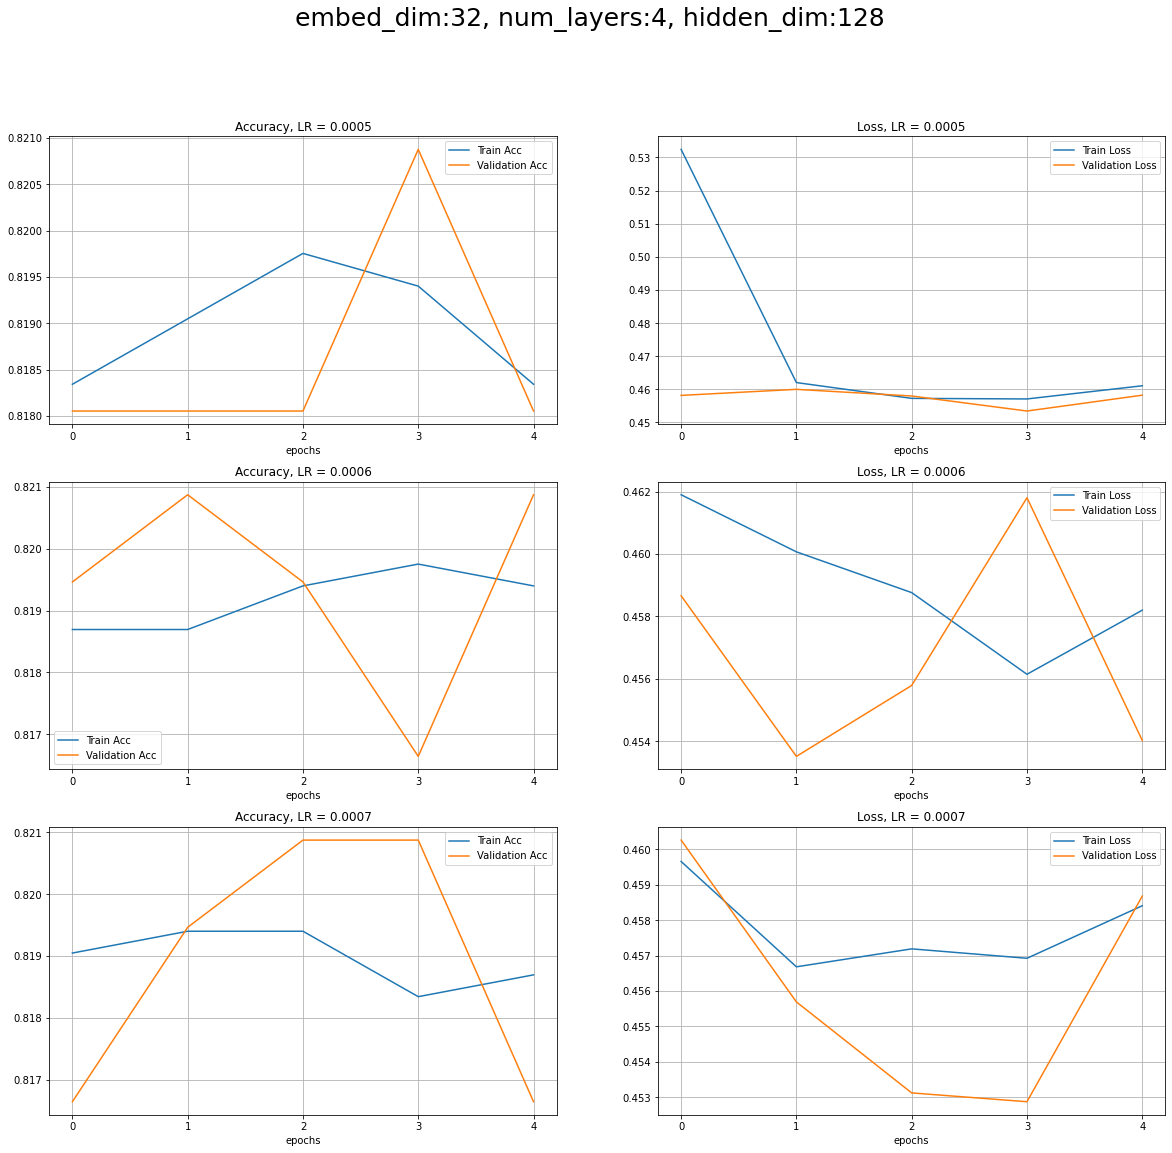

In [62]:
fig, ax = plt.subplots(len(lrs),2, figsize = (20,len(lrs)*6))
plt.suptitle(r'embed_dim:%d, num_layers:%d, hidden_dim:%d'%(embedding_dim, no_layers[1], hidden_dim[2]), fontsize = 25)
for i, lr in enumerate(lrs):
    ax[i][0].plot(epoch_tr_acc[i], label='Train Acc')
    ax[i][0].plot(epoch_vl_acc[i], label='Validation Acc')
    ax[i][0].set_xlabel('epochs')
    ax[i][0].set_xticks([0,1,2,3,4])
    ax[i][0].set_title('Accuracy, LR = %.4f'%lr)
    ax[i][0].legend()
    ax[i][0].grid()
    
    ax[i][1].plot(epoch_tr_loss[i], label='Train Loss')
    ax[i][1].plot(epoch_vl_loss[i], label='Validation Loss')
    ax[i][1].set_xlabel('epochs')
    ax[i][1].set_xticks([0,1,2,3,4])
    ax[i][1].set_title('Loss, LR = %.4f'%lr)
    ax[i][1].legend()
    ax[i][1].grid()
plt.savefig('/Users/bengieru/Desktop/NMA-DL/iSarcasm/Results/loss_acc_embed_dim:%d, no_layers:%d, hidden_dim:%d'%(embedding_dim, no_layers[1], hidden_dim[2]))

In [63]:
# Let's define our model
model = SentimentRNN(no_layers[2], vocab_size, hidden_dim[0],
                     embedding_dim, drop_prob=drop_prob)
# Moving to gpu
model.to(device)
print(model)

SentimentRNN(
  (embedding): Embedding(5000, 32)
  (lstm): LSTM(32, 32, num_layers=8, batch_first=True, dropout=0.25)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc): Linear(in_features=32, out_features=1, bias=True)
  (sig): Sigmoid()
)


In [64]:
# How many trainable parameters does our model have?
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print('Total Number of parameters: ',params)

Total Number of parameters:  227617


In [65]:
# loss and optimization functions
lrs = np.linspace(0.0005,0.0007,3)#define a range of learning rates

# Binary crossentropy is a good loss function for a binary classification problem
criterion = nn.BCELoss()

# We choose an Adam optimizer
optimizers = []
for i,lr in enumerate(lrs):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    optimizers.append(optimizer)
# function to predict accuracy
def acc(pred,label):
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == label.squeeze()).item()

In [66]:
# Number of training Epochs
epochs = 5

# Maximum absolute value accepted for the gradeint
clip = 5

# Initial Loss value (assumed big)
valid_loss_min = np.Inf

# Lists to follow the evolution of the loss and accuracy
epoch_tr_loss,epoch_vl_loss = [[] for i in range(len(lrs))],[[] for i in range(len(lrs))]
epoch_tr_acc,epoch_vl_acc = [[] for i in range(len(lrs))],[[] for i in range(len(lrs))]

# Train for a number of Epochs
for i, lr in enumerate(lrs):
    for epoch in range(epochs):
        train_losses = []
        train_acc = 0.0
        model.train()
  
        for inputs, labels in train_loader:

    # Initialize hidden state 
            h = model.init_hidden(batch_size)
    # Creating new variables for the hidden state
            h = tuple([each.data.to(device) for each in h])

    # Move batch inputs and labels to gpu
            inputs, labels = inputs.to(device), labels.to(device)   

    # Set gradient to zero
            model.zero_grad()

    # Compute model output
            output,h = model(inputs,h)

    # Calculate the loss and perform backprop
            loss = criterion(output.squeeze(), labels.float())
            loss.backward()
            train_losses.append(loss.item())

    # calculating accuracy
            accuracy = acc(output,labels)
            train_acc += accuracy

    #`clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
            nn.utils.clip_grad_norm_(model.parameters(), clip)
            optimizers[i].step()

  
  # Evaluate on the validation set for this epoch 
        val_losses = []
        val_acc = 0.0
        model.eval()
        for inputs, labels in valid_loader:

    # Initialize hidden state 
            val_h = model.init_hidden(batch_size)
            val_h = tuple([each.data.to(device) for each in val_h])

    # Move batch inputs and labels to gpu
            inputs, labels = inputs.to(device), labels.to(device)

    # Compute model output
            output, val_h = model(inputs, val_h)

    # Compute Loss
            val_loss = criterion(output.squeeze(), labels.float())

            val_losses.append(val_loss.item())

            accuracy = acc(output,labels)
            val_acc += accuracy
          
        epoch_train_loss = np.mean(train_losses)
        epoch_val_loss = np.mean(val_losses)
        epoch_train_acc = train_acc/len(train_loader.dataset)
        epoch_val_acc = val_acc/len(valid_loader.dataset)
        epoch_tr_loss[i].append(epoch_train_loss)
        epoch_vl_loss[i].append(epoch_val_loss)
        epoch_tr_acc[i].append(epoch_train_acc)
        epoch_vl_acc[i].append(epoch_val_acc)
        print(f'Epoch {epoch+1}') 
        print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
        print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}')
        if epoch_val_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,epoch_val_loss))
    # torch.save(model.state_dict(), '../working/state_dict.pt')
            valid_loss_min = epoch_val_loss
        print(25*'==')

Epoch 1
train_loss : 0.6558454803058079 val_loss : 0.6068066954612732
train_accuracy : 79.61199294532628 val_accuracy : 81.66431593794076
Validation loss decreased (inf --> 0.606807).  Saving model ...
Epoch 2
train_loss : 0.5187324093920844 val_loss : 0.45437473910195486
train_accuracy : 81.9753086419753 val_accuracy : 82.08744710860366
Validation loss decreased (0.606807 --> 0.454375).  Saving model ...
Epoch 3
train_loss : 0.46178867135729107 val_loss : 0.45605285678591045
train_accuracy : 81.83421516754849 val_accuracy : 81.94640338504936
Epoch 4
train_loss : 0.45796732285193037 val_loss : 0.4581943835530962
train_accuracy : 81.94003527336861 val_accuracy : 81.80535966149506
Epoch 5
train_loss : 0.4578245250242097 val_loss : 0.4559028318950108
train_accuracy : 82.04585537918871 val_accuracy : 81.94640338504936
Epoch 1
train_loss : 0.4601514892918723 val_loss : 0.45594254561832975
train_accuracy : 81.7989417989418 val_accuracy : 81.94640338504936
Epoch 2
train_loss : 0.4598672134535

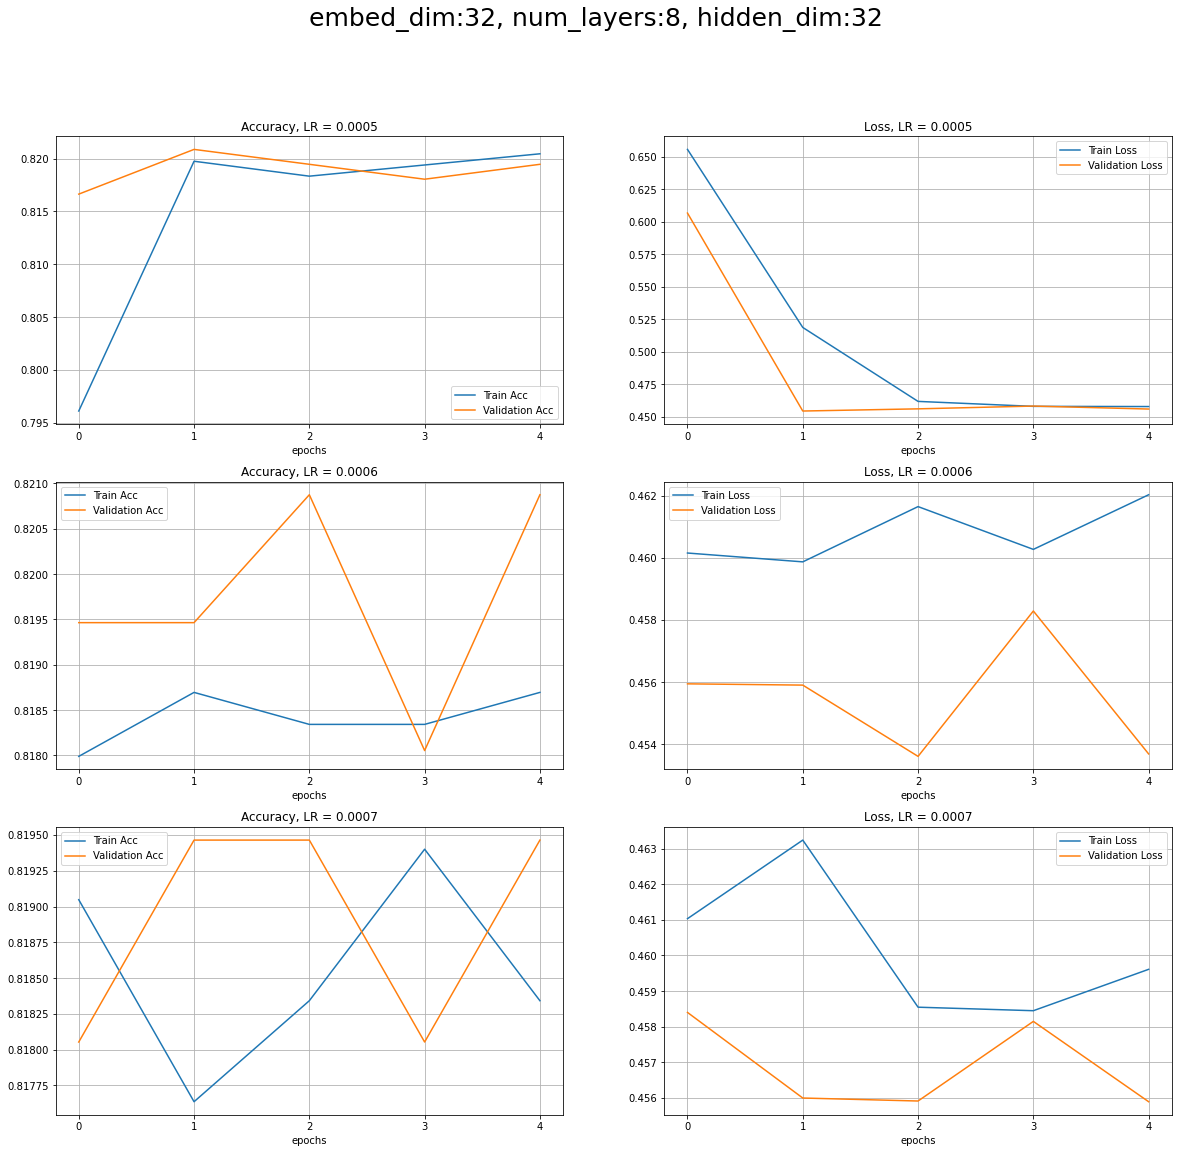

In [67]:
fig, ax = plt.subplots(len(lrs),2, figsize = (20,len(lrs)*6))
plt.suptitle(r'embed_dim:%d, num_layers:%d, hidden_dim:%d'%(embedding_dim, no_layers[2], hidden_dim[0]), fontsize = 25)
for i, lr in enumerate(lrs):
    ax[i][0].plot(epoch_tr_acc[i], label='Train Acc')
    ax[i][0].plot(epoch_vl_acc[i], label='Validation Acc')
    ax[i][0].set_xlabel('epochs')
    ax[i][0].set_xticks([0,1,2,3,4])
    ax[i][0].set_title('Accuracy, LR = %.4f'%lr)
    ax[i][0].legend()
    ax[i][0].grid()
    
    ax[i][1].plot(epoch_tr_loss[i], label='Train Loss')
    ax[i][1].plot(epoch_vl_loss[i], label='Validation Loss')
    ax[i][1].set_xlabel('epochs')
    ax[i][1].set_xticks([0,1,2,3,4])
    ax[i][1].set_title('Loss, LR = %.4f'%lr)
    ax[i][1].legend()
    ax[i][1].grid()
plt.savefig('/Users/bengieru/Desktop/NMA-DL/iSarcasm/Results/loss_acc_embed_dim:%d, no_layers:%d, hidden_dim:%d'%(embedding_dim, no_layers[2], hidden_dim[0]))

In [68]:
# Let's define our model
model = SentimentRNN(no_layers[2], vocab_size, hidden_dim[1],
                     embedding_dim, drop_prob=drop_prob)
# Moving to gpu
model.to(device)
print(model)

SentimentRNN(
  (embedding): Embedding(5000, 32)
  (lstm): LSTM(32, 64, num_layers=8, batch_first=True, dropout=0.25)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc): Linear(in_features=64, out_features=1, bias=True)
  (sig): Sigmoid()
)


In [69]:
# How many trainable parameters does our model have?
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print('Total Number of parameters: ',params)

Total Number of parameters:  418113


In [70]:
# loss and optimization functions
lrs = np.linspace(0.0005,0.0007,3)#define a range of learning rates

# Binary crossentropy is a good loss function for a binary classification problem
criterion = nn.BCELoss()

# We choose an Adam optimizer
optimizers = []
for i,lr in enumerate(lrs):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    optimizers.append(optimizer)
# function to predict accuracy
def acc(pred,label):
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == label.squeeze()).item()

In [71]:
# Number of training Epochs
epochs = 5

# Maximum absolute value accepted for the gradeint
clip = 5

# Initial Loss value (assumed big)
valid_loss_min = np.Inf

# Lists to follow the evolution of the loss and accuracy
epoch_tr_loss,epoch_vl_loss = [[] for i in range(len(lrs))],[[] for i in range(len(lrs))]
epoch_tr_acc,epoch_vl_acc = [[] for i in range(len(lrs))],[[] for i in range(len(lrs))]

# Train for a number of Epochs
for i, lr in enumerate(lrs):
    for epoch in range(epochs):
        train_losses = []
        train_acc = 0.0
        model.train()
  
        for inputs, labels in train_loader:

    # Initialize hidden state 
            h = model.init_hidden(batch_size)
    # Creating new variables for the hidden state
            h = tuple([each.data.to(device) for each in h])

    # Move batch inputs and labels to gpu
            inputs, labels = inputs.to(device), labels.to(device)   

    # Set gradient to zero
            model.zero_grad()

    # Compute model output
            output,h = model(inputs,h)

    # Calculate the loss and perform backprop
            loss = criterion(output.squeeze(), labels.float())
            loss.backward()
            train_losses.append(loss.item())

    # calculating accuracy
            accuracy = acc(output,labels)
            train_acc += accuracy

    #`clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
            nn.utils.clip_grad_norm_(model.parameters(), clip)
            optimizers[i].step()

  
  # Evaluate on the validation set for this epoch 
        val_losses = []
        val_acc = 0.0
        model.eval()
        for inputs, labels in valid_loader:

    # Initialize hidden state 
            val_h = model.init_hidden(batch_size)
            val_h = tuple([each.data.to(device) for each in val_h])

    # Move batch inputs and labels to gpu
            inputs, labels = inputs.to(device), labels.to(device)

    # Compute model output
            output, val_h = model(inputs, val_h)

    # Compute Loss
            val_loss = criterion(output.squeeze(), labels.float())

            val_losses.append(val_loss.item())

            accuracy = acc(output,labels)
            val_acc += accuracy
          
        epoch_train_loss = np.mean(train_losses)
        epoch_val_loss = np.mean(val_losses)
        epoch_train_acc = train_acc/len(train_loader.dataset)
        epoch_val_acc = val_acc/len(valid_loader.dataset)
        epoch_tr_loss[i].append(epoch_train_loss)
        epoch_vl_loss[i].append(epoch_val_loss)
        epoch_tr_acc[i].append(epoch_train_acc)
        epoch_vl_acc[i].append(epoch_val_acc)
        print(f'Epoch {epoch+1}') 
        print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
        print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}')
        if epoch_val_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,epoch_val_loss))
    # torch.save(model.state_dict(), '../working/state_dict.pt')
            valid_loss_min = epoch_val_loss
        print(25*'==')

Epoch 1
train_loss : 0.5713244176336697 val_loss : 0.46324184962681364
train_accuracy : 81.94003527336861 val_accuracy : 81.80535966149506
Validation loss decreased (inf --> 0.463242).  Saving model ...
Epoch 2
train_loss : 0.4629826971462795 val_loss : 0.457015722990036
train_accuracy : 82.08112874779542 val_accuracy : 81.94640338504936
Validation loss decreased (0.463242 --> 0.457016).  Saving model ...
Epoch 3
train_loss : 0.4620931191103799 val_loss : 0.46093337876456125
train_accuracy : 81.9047619047619 val_accuracy : 81.66431593794076
Epoch 4
train_loss : 0.4593182866062437 val_loss : 0.45365582619394573
train_accuracy : 82.01058201058201 val_accuracy : 82.08744710860366
Validation loss decreased (0.457016 --> 0.453656).  Saving model ...
Epoch 5
train_loss : 0.4601316015635218 val_loss : 0.46038815804890226
train_accuracy : 81.7989417989418 val_accuracy : 81.66431593794076
Epoch 1
train_loss : 0.4593745789357594 val_loss : 0.4539694232600076
train_accuracy : 81.9753086419753 val

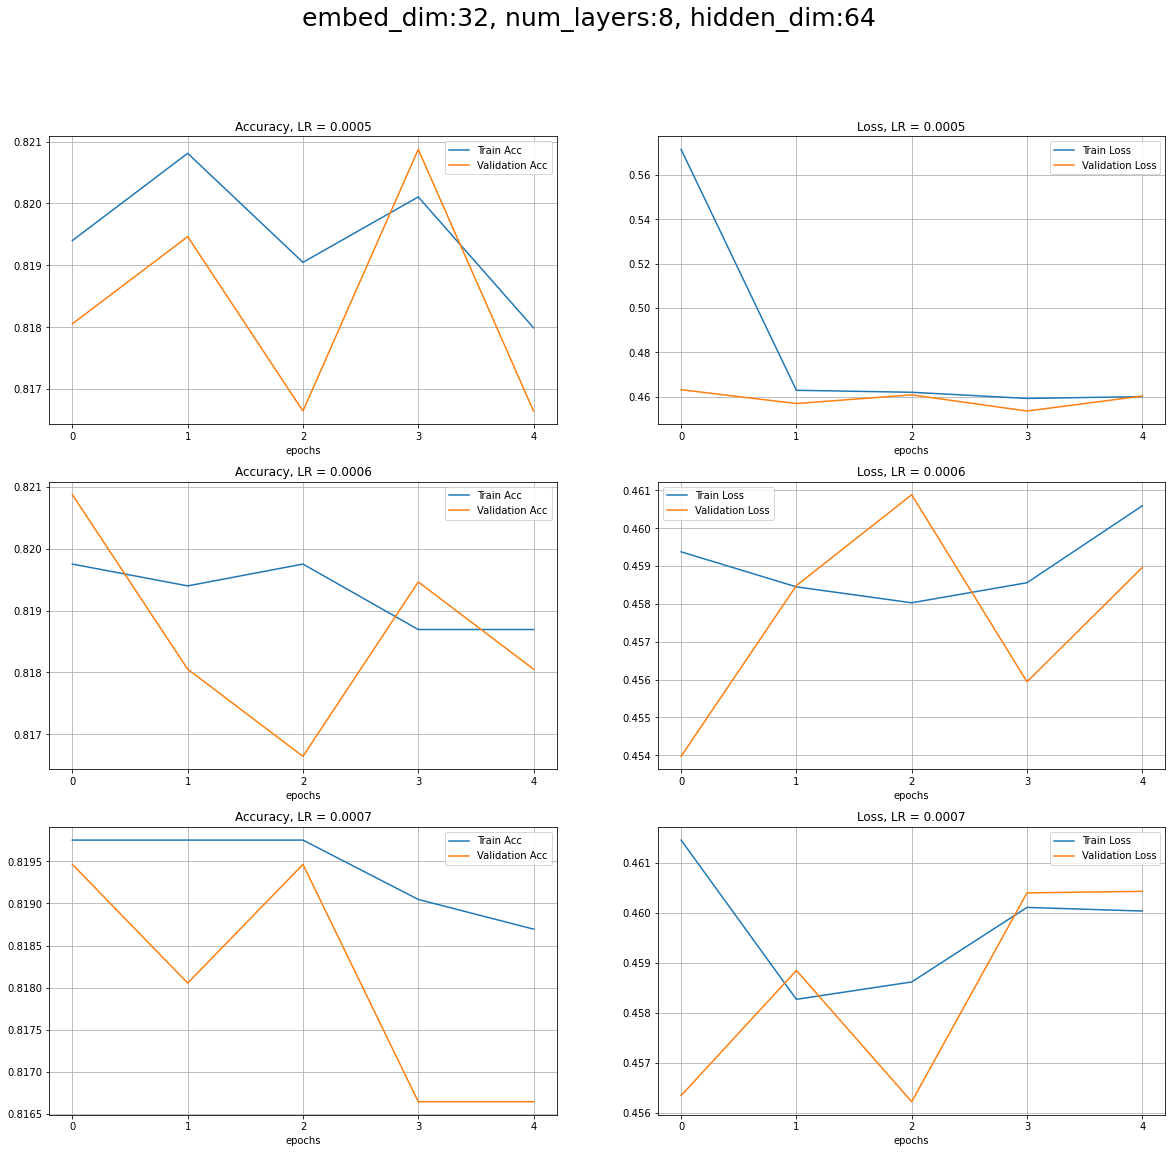

In [72]:
fig, ax = plt.subplots(len(lrs),2, figsize = (20,len(lrs)*6))
plt.suptitle(r'embed_dim:%d, num_layers:%d, hidden_dim:%d'%(embedding_dim, no_layers[2], hidden_dim[1]), fontsize = 25)
for i, lr in enumerate(lrs):
    ax[i][0].plot(epoch_tr_acc[i], label='Train Acc')
    ax[i][0].plot(epoch_vl_acc[i], label='Validation Acc')
    ax[i][0].set_xlabel('epochs')
    ax[i][0].set_xticks([0,1,2,3,4])
    ax[i][0].set_title('Accuracy, LR = %.4f'%lr)
    ax[i][0].legend()
    ax[i][0].grid()
    
    ax[i][1].plot(epoch_tr_loss[i], label='Train Loss')
    ax[i][1].plot(epoch_vl_loss[i], label='Validation Loss')
    ax[i][1].set_xlabel('epochs')
    ax[i][1].set_xticks([0,1,2,3,4])
    ax[i][1].set_title('Loss, LR = %.4f'%lr)
    ax[i][1].legend()
    ax[i][1].grid()
plt.savefig('/Users/bengieru/Desktop/NMA-DL/iSarcasm/Results/loss_acc_embed_dim:%d, no_layers:%d, hidden_dim:%d'%(embedding_dim, no_layers[2], hidden_dim[1]))

In [73]:
# Let's define our model
model = SentimentRNN(no_layers[2], vocab_size, hidden_dim[2],
                     embedding_dim, drop_prob=drop_prob)
# Moving to gpu
model.to(device)
print(model)

SentimentRNN(
  (embedding): Embedding(5000, 32)
  (lstm): LSTM(32, 128, num_layers=8, batch_first=True, dropout=0.25)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (sig): Sigmoid()
)


In [74]:
# How many trainable parameters does our model have?
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print('Total Number of parameters: ',params)

Total Number of parameters:  1167745


In [75]:
# loss and optimization functions
lrs = np.linspace(0.0005,0.0007,3)#define a range of learning rates

# Binary crossentropy is a good loss function for a binary classification problem
criterion = nn.BCELoss()

# We choose an Adam optimizer
optimizers = []
for i,lr in enumerate(lrs):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    optimizers.append(optimizer)
# function to predict accuracy
def acc(pred,label):
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == label.squeeze()).item()

In [76]:
# Number of training Epochs
epochs = 5

# Maximum absolute value accepted for the gradeint
clip = 5

# Initial Loss value (assumed big)
valid_loss_min = np.Inf

# Lists to follow the evolution of the loss and accuracy
epoch_tr_loss,epoch_vl_loss = [[] for i in range(len(lrs))],[[] for i in range(len(lrs))]
epoch_tr_acc,epoch_vl_acc = [[] for i in range(len(lrs))],[[] for i in range(len(lrs))]

# Train for a number of Epochs
for i, lr in enumerate(lrs):
    for epoch in range(epochs):
        train_losses = []
        train_acc = 0.0
        model.train()
  
        for inputs, labels in train_loader:

    # Initialize hidden state 
            h = model.init_hidden(batch_size)
    # Creating new variables for the hidden state
            h = tuple([each.data.to(device) for each in h])

    # Move batch inputs and labels to gpu
            inputs, labels = inputs.to(device), labels.to(device)   

    # Set gradient to zero
            model.zero_grad()

    # Compute model output
            output,h = model(inputs,h)

    # Calculate the loss and perform backprop
            loss = criterion(output.squeeze(), labels.float())
            loss.backward()
            train_losses.append(loss.item())

    # calculating accuracy
            accuracy = acc(output,labels)
            train_acc += accuracy

    #`clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
            nn.utils.clip_grad_norm_(model.parameters(), clip)
            optimizers[i].step()

  
  # Evaluate on the validation set for this epoch 
        val_losses = []
        val_acc = 0.0
        model.eval()
        for inputs, labels in valid_loader:

    # Initialize hidden state 
            val_h = model.init_hidden(batch_size)
            val_h = tuple([each.data.to(device) for each in val_h])

    # Move batch inputs and labels to gpu
            inputs, labels = inputs.to(device), labels.to(device)

    # Compute model output
            output, val_h = model(inputs, val_h)

    # Compute Loss
            val_loss = criterion(output.squeeze(), labels.float())

            val_losses.append(val_loss.item())

            accuracy = acc(output,labels)
            val_acc += accuracy
          
        epoch_train_loss = np.mean(train_losses)
        epoch_val_loss = np.mean(val_losses)
        epoch_train_acc = train_acc/len(train_loader.dataset)
        epoch_val_acc = val_acc/len(valid_loader.dataset)
        epoch_tr_loss[i].append(epoch_train_loss)
        epoch_vl_loss[i].append(epoch_val_loss)
        epoch_tr_acc[i].append(epoch_train_acc)
        epoch_vl_acc[i].append(epoch_val_acc)
        print(f'Epoch {epoch+1}') 
        print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
        print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}')
        if epoch_val_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,epoch_val_loss))
    # torch.save(model.state_dict(), '../working/state_dict.pt')
            valid_loss_min = epoch_val_loss
        print(25*'==')

Epoch 1
train_loss : 0.5502021429794175 val_loss : 0.463193552834647
train_accuracy : 76.5432098765432 val_accuracy : 81.66431593794076
Validation loss decreased (inf --> 0.463194).  Saving model ...
Epoch 2
train_loss : 0.4602690615824291 val_loss : 0.4562710310731615
train_accuracy : 81.9047619047619 val_accuracy : 81.94640338504936
Validation loss decreased (0.463194 --> 0.456271).  Saving model ...
Epoch 3
train_loss : 0.45957798404353006 val_loss : 0.4581624014036996
train_accuracy : 81.83421516754849 val_accuracy : 81.80535966149506
Epoch 4
train_loss : 0.4586544356175831 val_loss : 0.45362332463264465
train_accuracy : 81.9047619047619 val_accuracy : 82.08744710860366
Validation loss decreased (0.456271 --> 0.453623).  Saving model ...
Epoch 5
train_loss : 0.456780306994915 val_loss : 0.45431193709373474
train_accuracy : 81.94003527336861 val_accuracy : 82.08744710860366
Epoch 1
train_loss : 0.4595806119697435 val_loss : 0.4583126221384321
train_accuracy : 81.8694885361552 val_ac

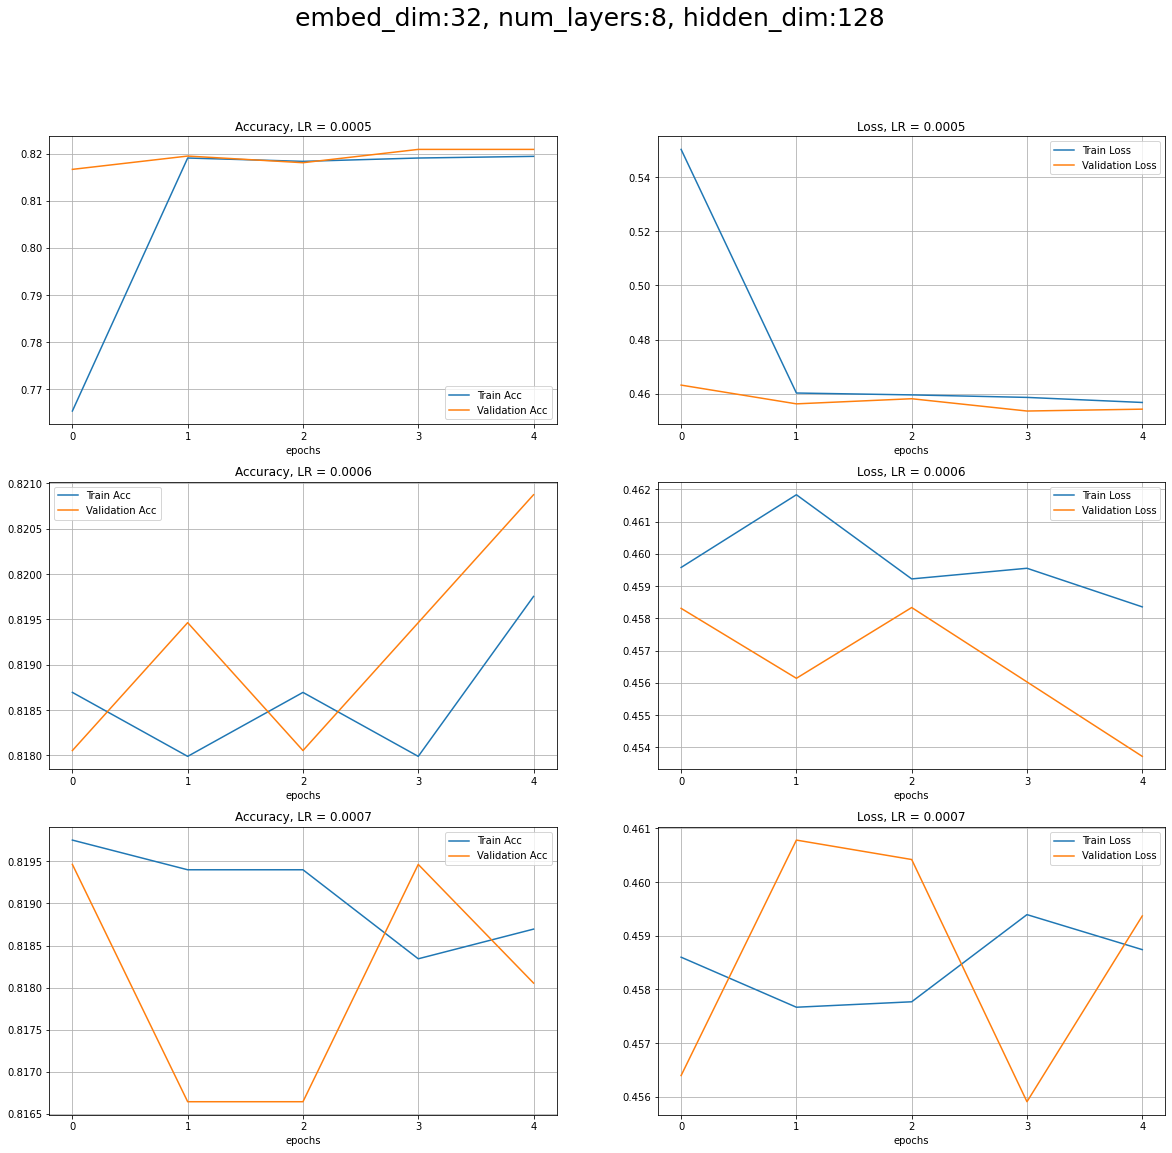

In [77]:
fig, ax = plt.subplots(len(lrs),2, figsize = (20,len(lrs)*6))
plt.suptitle(r'embed_dim:%d, num_layers:%d, hidden_dim:%d'%(embedding_dim, no_layers[2], hidden_dim[2]), fontsize = 25)
for i, lr in enumerate(lrs):
    ax[i][0].plot(epoch_tr_acc[i], label='Train Acc')
    ax[i][0].plot(epoch_vl_acc[i], label='Validation Acc')
    ax[i][0].set_xlabel('epochs')
    ax[i][0].set_xticks([0,1,2,3,4])
    ax[i][0].set_title('Accuracy, LR = %.4f'%lr)
    ax[i][0].legend()
    ax[i][0].grid()
    
    ax[i][1].plot(epoch_tr_loss[i], label='Train Loss')
    ax[i][1].plot(epoch_vl_loss[i], label='Validation Loss')
    ax[i][1].set_xlabel('epochs')
    ax[i][1].set_xticks([0,1,2,3,4])
    ax[i][1].set_title('Loss, LR = %.4f'%lr)
    ax[i][1].legend()
    ax[i][1].grid()
plt.savefig('/Users/bengieru/Desktop/NMA-DL/iSarcasm/Results/loss_acc_embed_dim:%d, no_layers:%d, hidden_dim:%d'%(embedding_dim, no_layers[2], hidden_dim[2]))